# IMPORTS

In [1]:
import os
import re
import math
import time
import torch
import random
import warnings
import numpy as np
import pandas as pd
import torch.nn as nn
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score, classification_report
from accelerate import Accelerator, notebook_launcher
from torch.multiprocessing import Manager
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel, BertPreTrainedModel, BertConfig, BertForSequenceClassification

# SETUP

In [2]:
warnings.filterwarnings('ignore')

In [3]:
if os.path.exists('/kaggle/working/results') == False:
    os.mkdir('/kaggle/working/results')

if os.path.exists('/kaggle/working/acquired_data') == False:
    os.mkdir('/kaggle/working/acquired_data')

In [4]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark=False

set_seed(42)

# GLOBAL VARIABLES

In [5]:
manager = Manager()

# Shared resources
accuracies = manager.list()
f1_micros = manager.list()
f1_macros = manager.list()
data_used = manager.list()
sampling_dur = manager.list()
new_samples = manager.list()

# Non shared resources
filename = 'hsd-kmeans'
epochs = 10
batch_size = 64
sequence_length = 80

# LOAD AND PREPROCESS DATA

In [6]:
data = pd.read_csv('/kaggle/input/multi-label-hate-speech/re_dataset.csv', encoding='latin-1')

alay_dict = pd.read_csv('/kaggle/input/multi-label-hate-speech/new_kamusalay.csv', encoding='latin-1', header=None)
alay_dict = alay_dict.rename(columns={0: 'original', 
                                      1: 'replacement'})

print("Shape: ", data.shape)
data.head()

Shape:  (13169, 13)


,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong
0,- disaat semua cowok berusaha melacak perhatia...,1,1,1,0,0,0,0,0,1,1,0,0
1,RT USER: USER siapa yang telat ngasih tau elu?...,0,1,0,0,0,0,0,0,0,0,0,0
2,"41. Kadang aku berfikir, kenapa aku tetap perc...",0,0,0,0,0,0,0,0,0,0,0,0
3,USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...,0,0,0,0,0,0,0,0,0,0,0,0
4,USER USER Kaum cebong kapir udah keliatan dong...,1,1,0,1,1,0,0,0,0,0,1,0


In [7]:
data.HS.value_counts()

HS
0    7608
1    5561
Name: count, dtype: int64

In [8]:
data.Abusive.value_counts()

Abusive
0    8126
1    5043
Name: count, dtype: int64

In [9]:
print("Shape: ", alay_dict.shape)
alay_dict.head(15)

Shape:  (15167, 2)


,original,replacement
0,anakjakartaasikasik,anak jakarta asyik asyik
1,pakcikdahtua,pak cik sudah tua
2,pakcikmudalagi,pak cik muda lagi
3,t3tapjokowi,tetap jokowi
4,3x,tiga kali
5,aamiin,amin
6,aamiinn,amin
7,aamin,amin
8,aammiin,amin
9,abis,habis


In [10]:
def lowercase(text):
    return text.lower()

def remove_unnecessary_char(text):
    text = re.sub('\n',' ',text) # Remove every '\n'
    text = re.sub('rt',' ',text) # Remove every retweet symbol
    text = re.sub('user',' ',text) # Remove every username
    text = re.sub('url', ' ', text) # Remove every URL
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))',' ',text) # Remove every URL
    text = re.sub(r'\b(?:x[a-fA-F0-9]{2}\s*)+\b', '', text) # Remove emoji bytecode
    text = re.sub('  +', ' ', text) # Remove extra spaces
    return text
    
def remove_nonaplhanumeric(text):
    text = re.sub('[^0-9a-zA-Z]+', ' ', text) 
    return text

alay_dict_map = dict(zip(alay_dict['original'], alay_dict['replacement']))
def normalize_alay(text):
    return ' '.join([alay_dict_map[word] if word in alay_dict_map else word for word in text.split(' ')])

print("remove_nonaplhanumeric: ", remove_nonaplhanumeric("Halooo,,,,, duniaa \x8f \xd2\1 !!"))
print("lowercase: ", lowercase("Halooo, duniaa!"))
print("remove_unnecessary_char: ", remove_unnecessary_char("Hehe\n\n RT USER USER apa kabs www.google.com\n  hehe URL xf8 x2a x89"))
print("normalize_alay: ", normalize_alay("aamiin adek abis"))

remove_nonaplhanumeric:  Halooo duniaa 
lowercase:  halooo, duniaa!
remove_unnecessary_char:  Hehe RT USER USER apa kabs hehe URL 
normalize_alay:  amin adik habis


In [11]:
def preprocess(text):
    text = lowercase(text)
    text = remove_nonaplhanumeric(text)
    text = remove_unnecessary_char(text)
    text = normalize_alay(text) 

    return text

In [12]:
data['Tweet'] = data['Tweet'].apply(preprocess)

# Define the labels columns for multi-label classification
label_columns = data.columns[1:]  # Assuming label columns start from the third column

train_data, val_data = train_test_split(data, test_size=0.2, random_state=42, shuffle=False)

# Extract features and labels for training and validation
X_train = train_data['Tweet'].values
y_train = train_data[label_columns].values
X_val = val_data['Tweet'].values
y_val = val_data[label_columns].values

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(10535,) (10535, 12)
(2634,) (2634, 12)


# BUILD DATASET & DATALOADERS

In [13]:
class HateSpeechDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128, use_float=True):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.use_float = use_float

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        labels = self.labels[idx]
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        item = {key: val.squeeze() for key, val in encoding.items()}
        item['labels'] = torch.tensor(labels, dtype=torch.float if self.use_float else torch.long)
        return item

# Initialize BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

In [14]:
def get_dataloaders(X_train, y_train, X_val, y_val, sequence_length=sequence_length, num_workers=4):
    train_dataset = HateSpeechDataset(X_train, y_train, tokenizer, max_length=sequence_length)
    val_dataset = HateSpeechDataset(X_val, y_val, tokenizer, max_length=sequence_length)
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=num_workers
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=num_workers
    )

    return train_loader, val_loader

# TRAIN THE MODEL

In [15]:
total_data = len(X_train) + len(X_val)
initial_train_size = int(0.05 * total_data)
checkpoints = [
    int(0.5 * total_data), 
    int(0.6 * total_data), 
    int(0.7 * total_data),
    len(X_train)
]
min_increment = 200

In [16]:
def compute_metrics(p):
    preds = torch.tensor(p.predictions) # Sigmoid and threshold for multi-label
    labels = torch.tensor(p.label_ids)

    # Hamming accuracy: proportion of correctly predicted labels over total labels
    accuracy = (preds == labels).float().mean().item()

    # Standard multi-label precision, recall, and F1 metrics
    precision, recall, f1_micro, _ = precision_recall_fscore_support(labels, preds, average='micro', zero_division=0)
    _, _, f1_macro, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0)

    report = classification_report(
        labels, 
        preds, 
        target_names=['HS', 'Abusive', 'HS_Individual', 'HS_Group', 'HS_Religion', 'HS_Race', 'HS_Physical', 'HS_Gender', 'HS_Other', 'HS_Weak', 'HS_Moderate', 'HS_Strong'],
        zero_division=0
    )   
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'report': report
    }

In [17]:
def train_model(current_train_size, train_indices, metrics, trials, seed):
    accelerator = Accelerator(mixed_precision='fp16')  # Initialize the accelerator
    device = accelerator.device

    accelerator.print(accelerator.distributed_type)

    with accelerator.main_process_first():
        model = BertForSequenceClassification.from_pretrained(
            'indobenchmark/indobert-base-p1',
            num_labels=len(label_columns),
            problem_type="multi_label_classification"
        )

    # Freeze the first few layers of the encoder
    for name, param in model.named_parameters():
        if "encoder.layer" in name:
            layer_num = name.split(".")[3]
            try:
                if int(layer_num) < 6:
                    param.requires_grad = False
            except ValueError:
                continue

    # Define DataLoaders
    current_X_train = [X_train[i] for i in train_indices]
    current_y_train = [y_train[i] for i in train_indices]
    train_loader, val_loader = get_dataloaders(current_X_train, current_y_train, X_val, y_val)

    # Define optimizer and loss function
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
    loss_fn = torch.nn.BCEWithLogitsLoss()

    # Prepare everything with Accelerator
    model, optimizer, train_loader, val_loader = accelerator.prepare(
        model, optimizer, train_loader, val_loader
    )

    best_result = None
    start_time = time.time()

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0

        for batch in train_loader:
            inputs = {key: val for key, val in batch.items() if key != 'labels'}
            labels = batch['labels']

            optimizer.zero_grad()
            outputs = model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            accelerator.backward(loss)
            optimizer.step()

            epoch_loss += loss.item()

        # Evaluation
        model.eval()
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for batch in val_loader:
                inputs = {key: val for key, val in batch.items() if key != 'labels'}
                labels = batch['labels']
                
                outputs = model(**inputs)
                preds = torch.sigmoid(outputs.logits).round()

                # Gather predictions and labels from all devices
                all_preds.append(accelerator.gather(preds))
                all_labels.append(accelerator.gather(labels))

        all_preds = torch.cat(all_preds).cpu().numpy()
        all_labels = torch.cat(all_labels).cpu().numpy()

        result = compute_metrics(type('EvalOutput', (object,), {'predictions': all_preds, 'label_ids': all_labels}))

        if best_result is None or result['f1_micro'] >= best_result['f1_micro']:
            accelerator.print("Higher F1 achieved, saving model")
            
            accelerator.wait_for_everyone()
            unwrapped_model = accelerator.unwrap_model(model)
            unwrapped_model.save_pretrained(
                f'{filename}-{trials + 1}-model',
                is_main_process=accelerator.is_main_process,
                save_function=accelerator.save,
            )
            best_result = result

        accelerator.print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {round(epoch_loss / len(train_loader), 4)}, Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")

    end_time = time.time()
    duration = end_time - start_time
    
    accelerator.print(f"\n Iteration {current_train_size}: Accuracy: {round(best_result['accuracy'], 4)}, F1 Micro: {round(best_result['f1_micro'], 4)}, F1 Macro: {round(best_result['f1_macro'], 4)}")
    accelerator.print(best_result['report'])
    accelerator.print(f"Training completed in {duration} s")

    # Update the shared lists
    if accelerator.is_local_main_process:
        metrics[0].append(current_train_size)
        metrics[1].append(best_result['accuracy'])
        metrics[2].append(best_result['f1_micro'])
        metrics[3].append(best_result['f1_macro'])

# PLOT THE RESULTS

In [18]:
import matplotlib.pyplot as plt

def plot_result(data_used, accuracies, f1_micros, f1_macros):
    fig, axs = plt.subplots(1, 3, figsize=(21, 5))
    data_used = [round(data / total_data * 100, 1) for data in data_used]

    # Plot for Accuracy
    axs[0].plot(data_used, accuracies, label="Accuracy", color="blue")
    axs[0].set_xlabel("Percentage of data used")
    axs[0].set_title("Accuracy")
    axs[0].set_xticks(data_used)

    # Plot for F1 Micro
    axs[1].plot(data_used, f1_micros, label="F1 Micro", color="orange")
    axs[1].set_xlabel("Percentage of data used")
    axs[1].set_title("F1 Micro")
    axs[1].set_xticks(data_used)

    # Plot for F1 Macro
    axs[2].plot(data_used, f1_macros, label="F1 Macro", color="green")
    axs[2].set_xlabel("Percentage of data used")
    axs[2].set_title("F1 Macro")
    axs[2].set_xticks(data_used)

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

# QUERY STRATEGY

In [19]:
def kmeans_clustering_sampling(model, X_pool, train_indices, remaining_indices, tokenizer, sampling_dur, new_samples, trials, n_clusters=min_increment):
    accelerator = Accelerator(mixed_precision="fp16")
    device = accelerator.device

    model.to(device)

    current_train_size = len(train_indices)
    dataset = HateSpeechDataset(X_pool, np.zeros((len(X_pool), 12)), tokenizer, max_length=sequence_length)
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=4,
        pin_memory=True,
    )

    model.eval()
    start_time = time.time()
    embeddings = []
    
    with torch.no_grad():
        for data in dataloader:
            input_ids = data['input_ids'].to(device)
            attention_mask = data['attention_mask'].to(device)
            outputs = model.base_model(input_ids=input_ids, attention_mask=attention_mask)
            hidden_states = outputs.last_hidden_state.mean(dim=1)  # Mean of hidden states for vector representation
            embeddings.append(hidden_states.cpu().numpy())
    
    # Convert embeddings list to numpy array
    embeddings = np.vstack(embeddings)
    embeddings = np.array(embeddings)
    
    collected_indices = set()  # Initialize set to store selected indices
    thresholds = []

    accelerator.wait_for_everyone()

    if accelerator.is_local_main_process:
        target_samples = len(embeddings[:math.ceil(0.1 * len(embeddings))])
    
        # Check nearest checkpoint
        nearest_cp = 0
        arrived_at_cp = False
        for cp in checkpoints:
            if cp > current_train_size:
                nearest_cp = cp
                break
                
        # Determine number of maximum samples to be acquired
        if target_samples <= n_clusters and n_clusters < nearest_cp - current_train_size:
            target_samples = n_clusters
        elif target_samples > n_clusters and target_samples < nearest_cp - current_train_size:
            target_samples = target_samples
        else:
            arrived_at_cp = True
            target_samples = nearest_cp - current_train_size

        # No clustering needed when there's little data left
        if current_train_size >= checkpoints[len(checkpoints)-1] - min_increment:
            end_time = time.time()
            duration = end_time - start_time
            
            temp = train_indices.copy()
            temp.extend(remaining_indices)
            
            # Save acquired data up to checkpoint
            acquired_data = pd.DataFrame({
                'processed_text': [X_train[i] for i in temp],
                'HS': [y_train[i][0] for i in temp],
                'Abusive': [y_train[i][1] for i in temp],
                'HS_Individual': [y_train[i][2] for i in temp],
                'HS_Group': [y_train[i][3] for i in temp],
                'HS_Religion': [y_train[i][4] for i in temp],
                'HS_Race': [y_train[i][5] for i in temp],
                'HS_Physical': [y_train[i][6] for i in temp],
                'HS_Gender': [y_train[i][7] for i in temp],
                'HS_Other': [y_train[i][8] for i in temp],
                'HS_Weak': [y_train[i][9] for i in temp],
                'HS_Moderate': [y_train[i][10] for i in temp],
                'HS_Strong': [y_train[i][11] for i in temp],
            })
            acquired_data.to_csv(f'acquired_data/{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)

            print("Nearest checkpoint:", nearest_cp)
            print("Acquired samples:", len(remaining_indices))
            print(f"Sampling duration: {duration} seconds")
            
            sampling_dur.append(duration)
            for i in remaining_indices:
                new_samples.append(i)
        else:
            # Cluster the data based on its embeddings
            kmeans=KMeans(n_clusters=n_clusters, n_init=1)
            kmeans.fit(embeddings)
            
            for cluster_id in range(n_clusters):
                # Cluster center and indices of samples in the current cluster
                cluster_center = kmeans.cluster_centers_[cluster_id]
                cluster_indices = np.where(kmeans.labels_ == cluster_id)[0]
            
                if cluster_indices.size == 0:
                    # Skip clusters with no members
                    print(f"Cluster {cluster_id} has no members, skipping.")
                    continue
            
                # Calculate distances of each point in the cluster from the cluster center
                cluster_distances = np.linalg.norm(embeddings[cluster_indices] - cluster_center, axis=1)
            
                # Determine the local threshold (10th percentile of closest distances to cluster center)
                local_threshold = np.percentile(cluster_distances, 90)
                thresholds.append(local_threshold)
            
                below_threshold_indices = cluster_indices[cluster_distances >= local_threshold]
                collected_indices.update(below_threshold_indices)

            # To handle multiple points with same distance
            if len(collected_indices) > target_samples:
                collected_indices = np.array(list(collected_indices))
                np.random.shuffle(collected_indices)
                collected_indices = collected_indices[:target_samples]
                
            end_time = time.time() 
            duration = end_time - start_time 
    
            if arrived_at_cp:
                temp = train_indices.copy()
                temp.extend(collected_indices)
                
                # Save acquired data up to checkpoint
                acquired_data = pd.DataFrame({
                    'processed_text': [X_train[i] for i in temp],
                    'HS': [y_train[i][0] for i in temp],
                    'Abusive': [y_train[i][1] for i in temp],
                    'HS_Individual': [y_train[i][2] for i in temp],
                    'HS_Group': [y_train[i][3] for i in temp],
                    'HS_Religion': [y_train[i][4] for i in temp],
                    'HS_Race': [y_train[i][5] for i in temp],
                    'HS_Physical': [y_train[i][6] for i in temp],
                    'HS_Gender': [y_train[i][7] for i in temp],
                    'HS_Other': [y_train[i][8] for i in temp],
                    'HS_Weak': [y_train[i][9] for i in temp],
                    'HS_Moderate': [y_train[i][10] for i in temp],
                    'HS_Strong': [y_train[i][11] for i in temp],
                })
        
                acquired_data.to_csv(f'acquired_data/{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)
            
            print("Nearest checkpoint:", nearest_cp)
            # print(f"Thresholds: {thresholds}")
            print("Acquired samples:", len(collected_indices))
            print(f"Sampling duration: {duration} seconds")
        
            sampling_dur.append(duration)
            for i in collected_indices:
                new_samples.append(remaining_indices[i])

        threshold_data = pd.DataFrame({
            'Threshold': thresholds
        })
        threshold_data.to_csv(f"results/{filename}-thresholds-{trials+1}-{current_train_size}.csv", index=False)

# MAIN LOOP

In [20]:
def active_learning(seed, i):
    accuracies = manager.list()
    f1_micros = manager.list()
    f1_macros = manager.list()
    data_used = manager.list()
    sampling_dur = manager.list()
    new_samples = manager.list()

    set_seed(seed)
    
    print("===============================================")
    print("TRIAL {}".format(i+1))
    print("Random seed:", seed)
    
    train_indices = np.random.choice(range(len(X_train)), initial_train_size, replace=False).tolist()
    remaining_indices = list(set(range(len(X_train))) - set(train_indices))
    
    current_train_size = initial_train_size
    
    start_time = time.time()
    while current_train_size < checkpoints[len(checkpoints) - 1]:
        # Train the model
        args = (current_train_size, train_indices, (data_used, accuracies, f1_micros, f1_macros), i, seed)
        notebook_launcher(train_model, args, num_processes=2)
        
        model = BertForSequenceClassification.from_pretrained(f'{filename}-{i + 1}-model')
    
        # Perform query strategy to select new samples
        new_samples = manager.list()
        sampling_args = (model, [X_train[i] for i in remaining_indices], train_indices, remaining_indices, tokenizer, sampling_dur, new_samples, i)
        notebook_launcher(kmeans_clustering_sampling, sampling_args, num_processes=2)
        new_samples = list(new_samples)
        train_indices.extend(new_samples)
        remaining_indices = list(set(remaining_indices) - set(new_samples))
    
        # Update current training size
        current_train_size = len(train_indices)
        print("New train size: {}".format(current_train_size))
    
    # Train last epoch
    args = (current_train_size, train_indices, (data_used, accuracies, f1_micros, f1_macros), i, seed)
    notebook_launcher(train_model, args, num_processes=2)
    data_used, accuracies, f1_micros, f1_macros, sampling_dur = list(data_used), list(accuracies), list(f1_micros), list(f1_macros), list(sampling_dur)
    
    end_time = time.time()
    duration = end_time - start_time
    
    print(f"Total sampling time: {np.array(sampling_dur).sum().round(2)} seconds")
    print(f"Total runtime: {duration} seconds")
    
    plot_result(data_used, accuracies, f1_micros, f1_macros)
    
    results = pd.DataFrame({
        'Data Used': data_used,
        'Accuracy': accuracies,
        'F1 Micro': f1_micros,
        'F1 Macro': f1_macros,
    })
    
    sampling_dur.insert(0, 0)
    results['Sampling Duration'] = sampling_dur
    results.to_csv(f'results/{filename}-{i+1}-results.csv', index=False)

In [21]:
seeds = [50, 81, 14, 3, 94]

## RUN 1

TRIAL 1
Random seed: 50
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6065, Accuracy: 0.8198, F1 Micro: 0.122, F1 Macro: 0.0444
Epoch 2/10, Train Loss: 0.4617, Accuracy: 0.8278, F1 Micro: 0.0007, F1 Macro: 0.0003
Epoch 3/10, Train Loss: 0.3954, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Epoch 4/10, Train Loss: 0.3949, Accuracy: 0.8281, F1 Micro: 0.0036, F1 Macro: 0.0016
Epoch 5/10, Train Loss: 0.3769, Accuracy: 0.8324, F1 Micro: 0.0595, F1 Macro: 0.0247
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3696, Accuracy: 0.8475, F1 Micro: 0.2419, F1 Macro: 0.0856
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3475, Accuracy: 0.8544, F1 Micro: 0.3196, F1 Macro: 0.1086
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3336, Accuracy: 0.8698, F1 Micro: 0.4829, F1 Macro: 0.2106
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2992, Accuracy: 0.8751, F1 Micro: 0.5435, F1 Macro: 0.2653
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.2712, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5282, Accuracy: 0.8278, F1 Micro: 0.0011, F1 Macro: 0.0004
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3854, Accuracy: 0.828, F1 Micro: 0.0029, F1 Macro: 0.0013
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3781, Accuracy: 0.8493, F1 Micro: 0.2738, F1 Macro: 0.0932
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3373, Accuracy: 0.8698, F1 Micro: 0.4773, F1 Macro: 0.2136
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3057, Accuracy: 0.8747, F1 Micro: 0.4961, F1 Macro: 0.2366
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2664, Accuracy: 0.8849, F1 Micro: 0.6342, F1 Macro: 0.3314
Epoch 7/10, Train Loss: 0.2365, Accuracy: 0.8828, F1 Micro: 0.564, F1 Macro: 0.327
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2167, Accuracy: 0.8872, F1 Micro: 0.6721, F1 Macro: 0.4427
Epoch 9/10, Train Loss: 0.1928, Accuracy: 0.8903, F1 Micro: 0.6251, F1 Macro: 0.4258
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4853, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3788, Accuracy: 0.839, F1 Micro: 0.1407, F1 Macro: 0.0541
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3455, Accuracy: 0.8771, F1 Micro: 0.5467, F1 Macro: 0.2518
Epoch 4/10, Train Loss: 0.2937, Accuracy: 0.8791, F1 Micro: 0.5397, F1 Macro: 0.2579
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2547, Accuracy: 0.8904, F1 Micro: 0.6671, F1 Macro: 0.3929
Epoch 6/10, Train Loss: 0.2205, Accuracy: 0.8937, F1 Micro: 0.6352, F1 Macro: 0.4069
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.191, Accuracy: 0.8979, F1 Micro: 0.694, F1 Macro: 0.4804
Epoch 8/10, Train Loss: 0.1633, Accuracy: 0.9, F1 Micro: 0.6768, F1 Macro: 0.4543
Epoch 9/10, Train Loss: 0.1458, Accuracy: 0.9011, F1 Micro: 0.6924, F1 Macro: 0.4803
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.1254, Accuracy: 0.9019

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4544, Accuracy: 0.8293, F1 Micro: 0.0213, F1 Macro: 0.0094
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3658, Accuracy: 0.8615, F1 Micro: 0.3932, F1 Macro: 0.1442
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3162, Accuracy: 0.8854, F1 Micro: 0.6334, F1 Macro: 0.3154
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2647, Accuracy: 0.8934, F1 Micro: 0.6517, F1 Macro: 0.371
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2235, Accuracy: 0.8986, F1 Micro: 0.6781, F1 Macro: 0.4441
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1923, Accuracy: 0.9005, F1 Micro: 0.7113, F1 Macro: 0.5144
Epoch 7/10, Train Loss: 0.1635, Accuracy: 0.9031, F1 Micro: 0.7033, F1 Macro: 0.5158
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1412, Accuracy: 0.9071, F1 Micro: 0.7175, F1 Macro: 0.5432
Epoch 9/10, Train Loss: 0.1227, Accuracy: 0.906, F1 Micro: 0.6923, F1 Macro: 0.5242
Higher

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4502, Accuracy: 0.8312, F1 Micro: 0.0446, F1 Macro: 0.0186
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3587, Accuracy: 0.8799, F1 Micro: 0.5782, F1 Macro: 0.2714
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2905, Accuracy: 0.8909, F1 Micro: 0.6358, F1 Macro: 0.339
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2464, Accuracy: 0.8975, F1 Micro: 0.6633, F1 Macro: 0.434
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2048, Accuracy: 0.9013, F1 Micro: 0.7059, F1 Macro: 0.4972
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1772, Accuracy: 0.9058, F1 Micro: 0.7214, F1 Macro: 0.5542
Epoch 7/10, Train Loss: 0.155, Accuracy: 0.908, F1 Micro: 0.7134, F1 Macro: 0.5628
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1284, Accuracy: 0.9094, F1 Micro: 0.7327, F1 Macro: 0.5691
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.11, Accuracy: 0.9104, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4447, Accuracy: 0.8382, F1 Micro: 0.1378, F1 Macro: 0.0526
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3446, Accuracy: 0.8807, F1 Micro: 0.5604, F1 Macro: 0.2704
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.279, Accuracy: 0.8966, F1 Micro: 0.6762, F1 Macro: 0.4532
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.233, Accuracy: 0.9027, F1 Micro: 0.6967, F1 Macro: 0.4857
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1999, Accuracy: 0.9067, F1 Micro: 0.7098, F1 Macro: 0.5368
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1691, Accuracy: 0.9091, F1 Micro: 0.7209, F1 Macro: 0.5477
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1391, Accuracy: 0.9114, F1 Micro: 0.7404, F1 Macro: 0.568
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1204, Accuracy: 0.9116, F1 Micro: 0.7412, F1 Macro: 0.589
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4354, Accuracy: 0.8419, F1 Micro: 0.1798, F1 Macro: 0.0667
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3306, Accuracy: 0.8863, F1 Micro: 0.596, F1 Macro: 0.2894
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.266, Accuracy: 0.8992, F1 Micro: 0.6829, F1 Macro: 0.4254
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2257, Accuracy: 0.9057, F1 Micro: 0.7016, F1 Macro: 0.4764
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1865, Accuracy: 0.9041, F1 Micro: 0.722, F1 Macro: 0.5536
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.164, Accuracy: 0.9067, F1 Micro: 0.7382, F1 Macro: 0.5569
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1353, Accuracy: 0.9108, F1 Micro: 0.7455, F1 Macro: 0.5793
Epoch 8/10, Train Loss: 0.1138, Accuracy: 0.9137, F1 Micro: 0.7368, F1 Macro: 0.5827
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0985, Accuracy: 0.9141, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4305, Accuracy: 0.852, F1 Micro: 0.3045, F1 Macro: 0.104
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3213, Accuracy: 0.8897, F1 Micro: 0.6402, F1 Macro: 0.3315
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2654, Accuracy: 0.9001, F1 Micro: 0.6506, F1 Macro: 0.4501
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2148, Accuracy: 0.9073, F1 Micro: 0.6911, F1 Macro: 0.4814
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1871, Accuracy: 0.9119, F1 Micro: 0.7401, F1 Macro: 0.5632
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1544, Accuracy: 0.9116, F1 Micro: 0.7408, F1 Macro: 0.5726
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1315, Accuracy: 0.9133, F1 Micro: 0.752, F1 Macro: 0.5978
Epoch 8/10, Train Loss: 0.1113, Accuracy: 0.9156, F1 Micro: 0.7508, F1 Macro: 0.5967
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0986, Accuracy: 0.9144, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4262, Accuracy: 0.859, F1 Micro: 0.3769, F1 Macro: 0.125
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.31, Accuracy: 0.8918, F1 Micro: 0.6451, F1 Macro: 0.3401
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2537, Accuracy: 0.9024, F1 Micro: 0.6929, F1 Macro: 0.5188
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2188, Accuracy: 0.9083, F1 Micro: 0.6949, F1 Macro: 0.4603
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1807, Accuracy: 0.9116, F1 Micro: 0.7399, F1 Macro: 0.5656
Epoch 6/10, Train Loss: 0.1518, Accuracy: 0.9097, F1 Micro: 0.7327, F1 Macro: 0.5629
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1311, Accuracy: 0.9091, F1 Micro: 0.747, F1 Macro: 0.6114
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1091, Accuracy: 0.9158, F1 Micro: 0.7591, F1 Macro: 0.6397
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0903, Accuracy: 0.9179, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4235, Accuracy: 0.8664, F1 Micro: 0.4971, F1 Macro: 0.1963
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3129, Accuracy: 0.8912, F1 Micro: 0.6328, F1 Macro: 0.3663
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2507, Accuracy: 0.9018, F1 Micro: 0.6663, F1 Macro: 0.4388
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2136, Accuracy: 0.9103, F1 Micro: 0.7281, F1 Macro: 0.5615
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1863, Accuracy: 0.9149, F1 Micro: 0.7416, F1 Macro: 0.5739
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1531, Accuracy: 0.917, F1 Micro: 0.7542, F1 Macro: 0.6081
Epoch 7/10, Train Loss: 0.1313, Accuracy: 0.9178, F1 Micro: 0.736, F1 Macro: 0.5966
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1071, Accuracy: 0.92, F1 Micro: 0.7567, F1 Macro: 0.637
Epoch 9/10, Train Loss: 0.0905, Accuracy: 0.9208, F1 Micro: 0.7534, F1 Macro: 0.642
Higher F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4186, Accuracy: 0.8728, F1 Micro: 0.528, F1 Macro: 0.232
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3018, Accuracy: 0.8925, F1 Micro: 0.6312, F1 Macro: 0.3223
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2407, Accuracy: 0.9031, F1 Micro: 0.7092, F1 Macro: 0.4859
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2071, Accuracy: 0.9102, F1 Micro: 0.7296, F1 Macro: 0.5659
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1729, Accuracy: 0.917, F1 Micro: 0.7459, F1 Macro: 0.5882
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1453, Accuracy: 0.9183, F1 Micro: 0.7542, F1 Macro: 0.6087
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1234, Accuracy: 0.9204, F1 Micro: 0.7555, F1 Macro: 0.6171
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1047, Accuracy: 0.9182, F1 Micro: 0.7599, F1 Macro: 0.6348
Epoch 9/10, Train Loss: 0.0853, Accuracy: 0.915, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4172, Accuracy: 0.8769, F1 Micro: 0.5562, F1 Macro: 0.2539
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2941, Accuracy: 0.8951, F1 Micro: 0.6642, F1 Macro: 0.4802
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2399, Accuracy: 0.9071, F1 Micro: 0.712, F1 Macro: 0.5317
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2025, Accuracy: 0.9132, F1 Micro: 0.7194, F1 Macro: 0.5523
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1709, Accuracy: 0.918, F1 Micro: 0.748, F1 Macro: 0.6002
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1452, Accuracy: 0.9206, F1 Micro: 0.7585, F1 Macro: 0.6258
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1167, Accuracy: 0.9207, F1 Micro: 0.762, F1 Macro: 0.6527
Epoch 8/10, Train Loss: 0.1032, Accuracy: 0.9187, F1 Micro: 0.7546, F1 Macro: 0.6463
Epoch 9/10, Train Loss: 0.0888, Accuracy: 0.9173, F1 Micro: 0.7618, F1 Macro: 0.6502
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4115, Accuracy: 0.8786, F1 Micro: 0.5902, F1 Macro: 0.281
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.296, Accuracy: 0.8971, F1 Micro: 0.656, F1 Macro: 0.4461
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2367, Accuracy: 0.9079, F1 Micro: 0.733, F1 Macro: 0.5459
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1978, Accuracy: 0.9141, F1 Micro: 0.7419, F1 Macro: 0.5821
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1647, Accuracy: 0.9157, F1 Micro: 0.7481, F1 Macro: 0.5861
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1419, Accuracy: 0.9183, F1 Micro: 0.7563, F1 Macro: 0.6263
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1187, Accuracy: 0.9186, F1 Micro: 0.7628, F1 Macro: 0.6399
Epoch 8/10, Train Loss: 0.1011, Accuracy: 0.9207, F1 Micro: 0.7565, F1 Macro: 0.6378
Epoch 9/10, Train Loss: 0.0849, Accuracy: 0.9211, F1 Micro: 0.7592, F1 Macro: 0.6483
Higher F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4116, Accuracy: 0.8733, F1 Micro: 0.4917, F1 Macro: 0.2261
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2878, Accuracy: 0.8992, F1 Micro: 0.6658, F1 Macro: 0.4479
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2343, Accuracy: 0.9099, F1 Micro: 0.7185, F1 Macro: 0.5356
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.194, Accuracy: 0.9135, F1 Micro: 0.7488, F1 Macro: 0.5824
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1632, Accuracy: 0.9191, F1 Micro: 0.7569, F1 Macro: 0.6143
Epoch 6/10, Train Loss: 0.1344, Accuracy: 0.92, F1 Micro: 0.7551, F1 Macro: 0.6115
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1157, Accuracy: 0.9231, F1 Micro: 0.7675, F1 Macro: 0.6614
Epoch 8/10, Train Loss: 0.0987, Accuracy: 0.923, F1 Micro: 0.7674, F1 Macro: 0.6669
Epoch 9/10, Train Loss: 0.0806, Accuracy: 0.9205, F1 Micro: 0.7613, F1 Macro: 0.6592
Epoch 10/10, Train Loss: 0.0709, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4044, Accuracy: 0.8788, F1 Micro: 0.553, F1 Macro: 0.2609
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2879, Accuracy: 0.8997, F1 Micro: 0.6562, F1 Macro: 0.4201
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2312, Accuracy: 0.9109, F1 Micro: 0.7223, F1 Macro: 0.5451
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1948, Accuracy: 0.9166, F1 Micro: 0.7431, F1 Macro: 0.5841
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1661, Accuracy: 0.9162, F1 Micro: 0.7542, F1 Macro: 0.5939
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1366, Accuracy: 0.9217, F1 Micro: 0.7662, F1 Macro: 0.6357
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1196, Accuracy: 0.9223, F1 Micro: 0.7677, F1 Macro: 0.6654
Epoch 8/10, Train Loss: 0.1015, Accuracy: 0.9191, F1 Micro: 0.7646, F1 Macro: 0.6689
Epoch 9/10, Train Loss: 0.0832, Accuracy: 0.9191, F1 Micro: 0.7647, F1 Macro: 0.6634
Epoch

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4052, Accuracy: 0.881, F1 Micro: 0.6021, F1 Macro: 0.2851
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2838, Accuracy: 0.9002, F1 Micro: 0.6925, F1 Macro: 0.4896
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2328, Accuracy: 0.9115, F1 Micro: 0.7255, F1 Macro: 0.5351
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1918, Accuracy: 0.9158, F1 Micro: 0.7506, F1 Macro: 0.5882
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1587, Accuracy: 0.9189, F1 Micro: 0.7623, F1 Macro: 0.6116
Epoch 6/10, Train Loss: 0.1376, Accuracy: 0.9193, F1 Micro: 0.7546, F1 Macro: 0.6159
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1171, Accuracy: 0.917, F1 Micro: 0.7662, F1 Macro: 0.6613
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0974, Accuracy: 0.9205, F1 Micro: 0.7719, F1 Macro: 0.6717
Epoch 9/10, Train Loss: 0.0841, Accuracy: 0.9225, F1 Micro: 0.764, F1 Macro: 0.664
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4014, Accuracy: 0.8819, F1 Micro: 0.6163, F1 Macro: 0.3046
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2753, Accuracy: 0.9014, F1 Micro: 0.681, F1 Macro: 0.4355
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2232, Accuracy: 0.9115, F1 Micro: 0.7149, F1 Macro: 0.5267
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1871, Accuracy: 0.9149, F1 Micro: 0.7514, F1 Macro: 0.6036
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1577, Accuracy: 0.9186, F1 Micro: 0.7591, F1 Macro: 0.6031
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1319, Accuracy: 0.921, F1 Micro: 0.7641, F1 Macro: 0.6299
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.109, Accuracy: 0.9195, F1 Micro: 0.7729, F1 Macro: 0.669
Epoch 8/10, Train Loss: 0.0973, Accuracy: 0.921, F1 Micro: 0.769, F1 Macro: 0.6546
Epoch 9/10, Train Loss: 0.0831, Accuracy: 0.9211, F1 Micro: 0.772, F1 Macro: 0.6806
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4018, Accuracy: 0.8801, F1 Micro: 0.554, F1 Macro: 0.2616
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2749, Accuracy: 0.9005, F1 Micro: 0.6593, F1 Macro: 0.4572
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2255, Accuracy: 0.9121, F1 Micro: 0.7252, F1 Macro: 0.5403
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1885, Accuracy: 0.9152, F1 Micro: 0.755, F1 Macro: 0.6023
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1624, Accuracy: 0.9179, F1 Micro: 0.7631, F1 Macro: 0.6163
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1336, Accuracy: 0.9201, F1 Micro: 0.7653, F1 Macro: 0.6322
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1163, Accuracy: 0.9228, F1 Micro: 0.7718, F1 Macro: 0.6645
Epoch 8/10, Train Loss: 0.0951, Accuracy: 0.9217, F1 Micro: 0.7689, F1 Macro: 0.6728
Epoch 9/10, Train Loss: 0.082, Accuracy: 0.92, F1 Micro: 0.7657, F1 Macro: 0.657
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3954, Accuracy: 0.884, F1 Micro: 0.6266, F1 Macro: 0.3132
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2712, Accuracy: 0.9036, F1 Micro: 0.6908, F1 Macro: 0.4274
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2216, Accuracy: 0.9123, F1 Micro: 0.7348, F1 Macro: 0.5465
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1836, Accuracy: 0.9175, F1 Micro: 0.7562, F1 Macro: 0.5996
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1584, Accuracy: 0.9197, F1 Micro: 0.758, F1 Macro: 0.6009
Epoch 6/10, Train Loss: 0.1316, Accuracy: 0.9222, F1 Micro: 0.7576, F1 Macro: 0.6347
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1095, Accuracy: 0.9225, F1 Micro: 0.7638, F1 Macro: 0.6487
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0926, Accuracy: 0.9238, F1 Micro: 0.7678, F1 Macro: 0.6764
Epoch 9/10, Train Loss: 0.0826, Accuracy: 0.9192, F1 Micro: 0.7652, F1 Macro: 0.684
Higher 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3984, Accuracy: 0.8842, F1 Micro: 0.5952, F1 Macro: 0.2961
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2716, Accuracy: 0.9045, F1 Micro: 0.7092, F1 Macro: 0.4956
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.222, Accuracy: 0.9103, F1 Micro: 0.7392, F1 Macro: 0.5658
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1849, Accuracy: 0.9194, F1 Micro: 0.7457, F1 Macro: 0.5943
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1554, Accuracy: 0.9152, F1 Micro: 0.7639, F1 Macro: 0.6541
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1319, Accuracy: 0.9193, F1 Micro: 0.77, F1 Macro: 0.662
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1111, Accuracy: 0.9245, F1 Micro: 0.7709, F1 Macro: 0.6699
Epoch 8/10, Train Loss: 0.0932, Accuracy: 0.9232, F1 Micro: 0.7696, F1 Macro: 0.656
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0767, Accuracy: 0.9246, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3941, Accuracy: 0.8832, F1 Micro: 0.6086, F1 Macro: 0.2996
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2723, Accuracy: 0.9028, F1 Micro: 0.671, F1 Macro: 0.455
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2191, Accuracy: 0.9133, F1 Micro: 0.7275, F1 Macro: 0.5345
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1857, Accuracy: 0.9179, F1 Micro: 0.7535, F1 Macro: 0.6007
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1543, Accuracy: 0.9183, F1 Micro: 0.7638, F1 Macro: 0.6235
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1267, Accuracy: 0.923, F1 Micro: 0.7712, F1 Macro: 0.6563
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1066, Accuracy: 0.9248, F1 Micro: 0.779, F1 Macro: 0.6796
Epoch 8/10, Train Loss: 0.0923, Accuracy: 0.9236, F1 Micro: 0.77, F1 Macro: 0.6653
Epoch 9/10, Train Loss: 0.0805, Accuracy: 0.9241, F1 Micro: 0.77, F1 Macro: 0.6897
Epoch 10/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3959, Accuracy: 0.8849, F1 Micro: 0.5918, F1 Macro: 0.2967
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2728, Accuracy: 0.9017, F1 Micro: 0.713, F1 Macro: 0.5232
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2194, Accuracy: 0.9125, F1 Micro: 0.7196, F1 Macro: 0.5381
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.188, Accuracy: 0.9201, F1 Micro: 0.7616, F1 Macro: 0.6244
Epoch 5/10, Train Loss: 0.1567, Accuracy: 0.9208, F1 Micro: 0.7484, F1 Macro: 0.6084
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1299, Accuracy: 0.9208, F1 Micro: 0.7677, F1 Macro: 0.6626
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1086, Accuracy: 0.9235, F1 Micro: 0.7683, F1 Macro: 0.6674
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0912, Accuracy: 0.9224, F1 Micro: 0.7693, F1 Macro: 0.6814
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0817, Accuracy: 0.9229, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3908, Accuracy: 0.8848, F1 Micro: 0.6079, F1 Macro: 0.3098
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2664, Accuracy: 0.9064, F1 Micro: 0.7079, F1 Macro: 0.4965
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2182, Accuracy: 0.9139, F1 Micro: 0.7417, F1 Macro: 0.5476
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1846, Accuracy: 0.92, F1 Micro: 0.7661, F1 Macro: 0.6151
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1521, Accuracy: 0.9213, F1 Micro: 0.7664, F1 Macro: 0.6505
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1269, Accuracy: 0.9253, F1 Micro: 0.7732, F1 Macro: 0.663
Epoch 7/10, Train Loss: 0.1089, Accuracy: 0.924, F1 Micro: 0.773, F1 Macro: 0.6723
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0901, Accuracy: 0.9237, F1 Micro: 0.7746, F1 Macro: 0.6838
Epoch 9/10, Train Loss: 0.079, Accuracy: 0.9204, F1 Micro: 0.7727, F1 Macro: 0.6825
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3896, Accuracy: 0.8866, F1 Micro: 0.6304, F1 Macro: 0.3074
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2645, Accuracy: 0.9056, F1 Micro: 0.716, F1 Macro: 0.5294
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.217, Accuracy: 0.9155, F1 Micro: 0.74, F1 Macro: 0.5561
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1801, Accuracy: 0.9186, F1 Micro: 0.7644, F1 Macro: 0.6196
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1504, Accuracy: 0.9208, F1 Micro: 0.7697, F1 Macro: 0.6386
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1269, Accuracy: 0.921, F1 Micro: 0.7732, F1 Macro: 0.6868
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1069, Accuracy: 0.9243, F1 Micro: 0.7797, F1 Macro: 0.6848
Epoch 8/10, Train Loss: 0.0884, Accuracy: 0.9249, F1 Micro: 0.7748, F1 Macro: 0.6918
Epoch 9/10, Train Loss: 0.0744, Accuracy: 0.9218, F1 Micro: 0.7715, F1 Macro: 0.6993
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3875, Accuracy: 0.8875, F1 Micro: 0.6425, F1 Macro: 0.33
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2591, Accuracy: 0.9043, F1 Micro: 0.7196, F1 Macro: 0.5413
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2086, Accuracy: 0.9151, F1 Micro: 0.7456, F1 Macro: 0.5803
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1822, Accuracy: 0.9187, F1 Micro: 0.7634, F1 Macro: 0.6134
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1481, Accuracy: 0.9188, F1 Micro: 0.7686, F1 Macro: 0.6537
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1233, Accuracy: 0.925, F1 Micro: 0.7728, F1 Macro: 0.6841
Epoch 7/10, Train Loss: 0.1027, Accuracy: 0.9241, F1 Micro: 0.7706, F1 Macro: 0.678
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0882, Accuracy: 0.9226, F1 Micro: 0.775, F1 Macro: 0.6815
Epoch 9/10, Train Loss: 0.0778, Accuracy: 0.9209, F1 Micro: 0.7716, F1 Macro: 0.6919
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3845, Accuracy: 0.8874, F1 Micro: 0.6076, F1 Macro: 0.2941
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2544, Accuracy: 0.9065, F1 Micro: 0.6915, F1 Macro: 0.5043
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2067, Accuracy: 0.9173, F1 Micro: 0.7517, F1 Macro: 0.5819
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1755, Accuracy: 0.9222, F1 Micro: 0.7658, F1 Macro: 0.6327
Epoch 5/10, Train Loss: 0.1476, Accuracy: 0.9229, F1 Micro: 0.7626, F1 Macro: 0.6283
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1194, Accuracy: 0.9238, F1 Micro: 0.7762, F1 Macro: 0.6761
Epoch 7/10, Train Loss: 0.1039, Accuracy: 0.9227, F1 Micro: 0.774, F1 Macro: 0.677
Epoch 8/10, Train Loss: 0.0866, Accuracy: 0.9238, F1 Micro: 0.7718, F1 Macro: 0.6892
Epoch 9/10, Train Loss: 0.0777, Accuracy: 0.9245, F1 Micro: 0.7743, F1 Macro: 0.6969
Epoch 10/10, Train Loss: 0.0649, Accuracy: 0.9204, F1 Micro: 0.7747, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3741, Accuracy: 0.8869, F1 Micro: 0.5986, F1 Macro: 0.3155
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2518, Accuracy: 0.9087, F1 Micro: 0.7129, F1 Macro: 0.5314
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2021, Accuracy: 0.9184, F1 Micro: 0.7474, F1 Macro: 0.5822
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1708, Accuracy: 0.922, F1 Micro: 0.7674, F1 Macro: 0.6189
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1441, Accuracy: 0.9244, F1 Micro: 0.7693, F1 Macro: 0.625
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1206, Accuracy: 0.924, F1 Micro: 0.77, F1 Macro: 0.6727
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0966, Accuracy: 0.9231, F1 Micro: 0.772, F1 Macro: 0.682
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0837, Accuracy: 0.92, F1 Micro: 0.7738, F1 Macro: 0.6796
Epoch 9/10, Train Loss: 0.0723, Accuracy: 0.9218, F1 Micro: 0.771

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3733, Accuracy: 0.8881, F1 Micro: 0.6311, F1 Macro: 0.331
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2503, Accuracy: 0.9038, F1 Micro: 0.7235, F1 Macro: 0.5545
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2061, Accuracy: 0.9164, F1 Micro: 0.7444, F1 Macro: 0.5918
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1685, Accuracy: 0.9203, F1 Micro: 0.7577, F1 Macro: 0.6105
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1424, Accuracy: 0.9228, F1 Micro: 0.763, F1 Macro: 0.6539
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1204, Accuracy: 0.9204, F1 Micro: 0.7701, F1 Macro: 0.6618
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1012, Accuracy: 0.9225, F1 Micro: 0.777, F1 Macro: 0.6833
Epoch 8/10, Train Loss: 0.0822, Accuracy: 0.9239, F1 Micro: 0.7746, F1 Macro: 0.6886
Epoch 9/10, Train Loss: 0.0712, Accuracy: 0.9213, F1 Micro: 0.7733, F1 Macro: 0.7028
Epoch 1

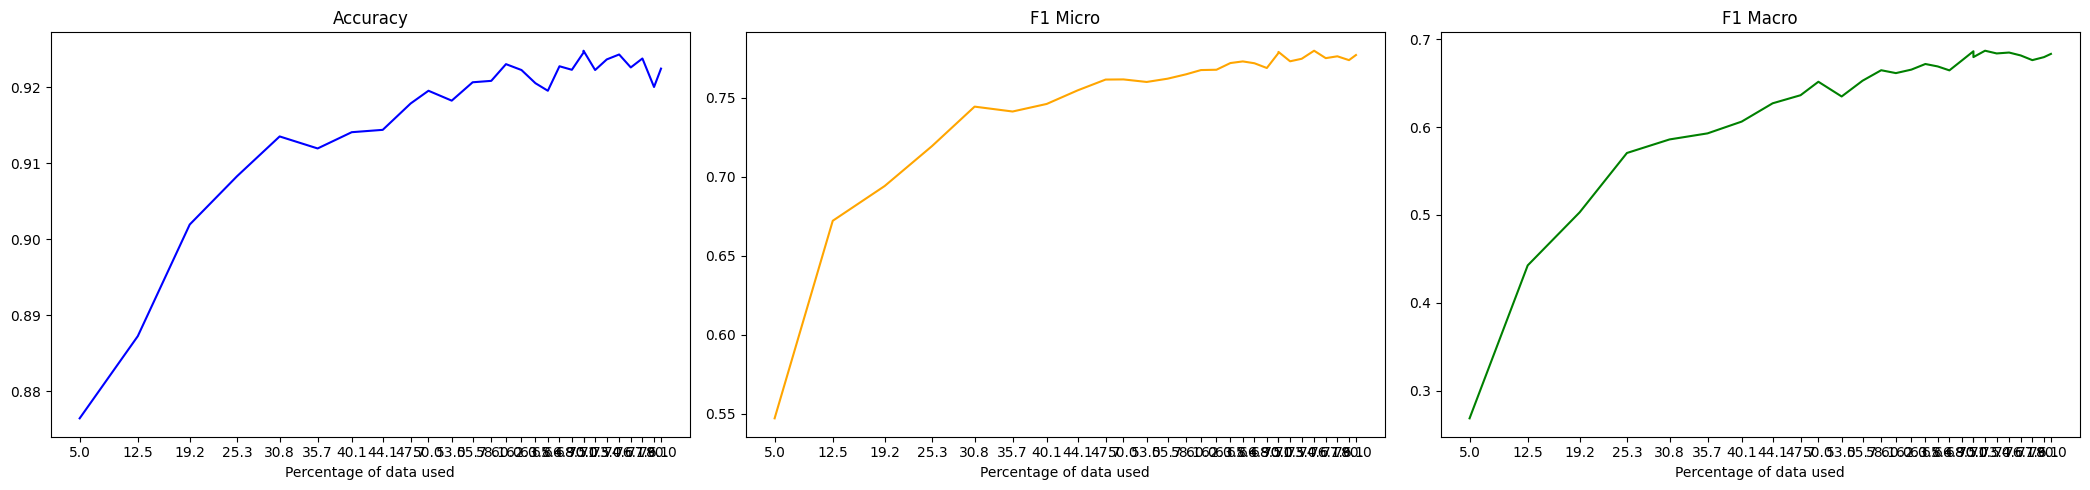

In [ ]:
active_learning(seeds[0], 0)

## RUN 2

TRIAL 2
Random seed: 81
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5815, Accuracy: 0.8273, F1 Micro: 0.3943, F1 Macro: 0.1042
Epoch 2/10, Train Loss: 0.4544, Accuracy: 0.8345, F1 Micro: 0.2205, F1 Macro: 0.0565
Epoch 3/10, Train Loss: 0.4043, Accuracy: 0.8322, F1 Micro: 0.0793, F1 Macro: 0.0316
Epoch 4/10, Train Loss: 0.3672, Accuracy: 0.8369, F1 Micro: 0.1519, F1 Macro: 0.0501
Epoch 5/10, Train Loss: 0.3623, Accuracy: 0.8455, F1 Micro: 0.2415, F1 Macro: 0.0848
Epoch 6/10, Train Loss: 0.3367, Accuracy: 0.8517, F1 Micro: 0.3286, F1 Macro: 0.1153
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3235, Accuracy: 0.8681, F1 Micro: 0.4938, F1 Macro: 0.2278
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3035, Accuracy: 0.8719, F1 Micro: 0.5345, F1 Macro: 0.2502
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2634, Accuracy: 0.8738, F1 Micro: 0.5938, F1 Macro: 0.278
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.2673, Accuracy: 0.8758, F1 Micro: 0.5957, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.509, Accuracy: 0.8317, F1 Micro: 0.1185, F1 Macro: 0.0356
Epoch 2/10, Train Loss: 0.3834, Accuracy: 0.8313, F1 Micro: 0.0516, F1 Macro: 0.021
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3544, Accuracy: 0.8531, F1 Micro: 0.3271, F1 Macro: 0.1266
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3274, Accuracy: 0.8736, F1 Micro: 0.5406, F1 Macro: 0.2561
Epoch 5/10, Train Loss: 0.2895, Accuracy: 0.875, F1 Micro: 0.5061, F1 Macro: 0.238
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2599, Accuracy: 0.8847, F1 Micro: 0.6292, F1 Macro: 0.324
Epoch 7/10, Train Loss: 0.2364, Accuracy: 0.8831, F1 Micro: 0.5622, F1 Macro: 0.2843
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2226, Accuracy: 0.8879, F1 Micro: 0.6547, F1 Macro: 0.4003
Epoch 9/10, Train Loss: 0.1855, Accuracy: 0.8895, F1 Micro: 0.6169, F1 Macro: 0.3739
Epoch 10/10, Train Loss: 0.1757, Accuracy: 0.8914, F1 Micro: 0.653, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4724, Accuracy: 0.8293, F1 Micro: 0.0255, F1 Macro: 0.0111
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3626, Accuracy: 0.8424, F1 Micro: 0.2154, F1 Macro: 0.0729
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3273, Accuracy: 0.8745, F1 Micro: 0.5219, F1 Macro: 0.2459
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2937, Accuracy: 0.8841, F1 Micro: 0.5771, F1 Macro: 0.2822
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2473, Accuracy: 0.8911, F1 Micro: 0.6373, F1 Macro: 0.3458
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2202, Accuracy: 0.893, F1 Micro: 0.6482, F1 Macro: 0.3834
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1896, Accuracy: 0.8964, F1 Micro: 0.6794, F1 Macro: 0.4694
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1664, Accuracy: 0.8972, F1 Micro: 0.6921, F1 Macro: 0.4855
Epoch 9/10, Train Loss: 0.1486, Accuracy: 0.9002, F1 Micr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4531, Accuracy: 0.828, F1 Micro: 0.0064, F1 Macro: 0.0029
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3517, Accuracy: 0.8677, F1 Micro: 0.4932, F1 Macro: 0.2269
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3067, Accuracy: 0.8857, F1 Micro: 0.5954, F1 Macro: 0.2835
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2632, Accuracy: 0.8904, F1 Micro: 0.6621, F1 Macro: 0.373
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2257, Accuracy: 0.8951, F1 Micro: 0.6917, F1 Macro: 0.4603
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1934, Accuracy: 0.898, F1 Micro: 0.6987, F1 Macro: 0.4911
Epoch 7/10, Train Loss: 0.1712, Accuracy: 0.9028, F1 Micro: 0.6958, F1 Macro: 0.5049
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.144, Accuracy: 0.8999, F1 Micro: 0.7099, F1 Macro: 0.5245
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1278, Accuracy: 0.907, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4402, Accuracy: 0.8372, F1 Micro: 0.1345, F1 Macro: 0.0516
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3409, Accuracy: 0.8745, F1 Micro: 0.5243, F1 Macro: 0.2439
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.292, Accuracy: 0.8876, F1 Micro: 0.6584, F1 Macro: 0.3344
Epoch 4/10, Train Loss: 0.2478, Accuracy: 0.8971, F1 Micro: 0.6556, F1 Macro: 0.3934
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2107, Accuracy: 0.9031, F1 Micro: 0.7126, F1 Macro: 0.53
Epoch 6/10, Train Loss: 0.1869, Accuracy: 0.9073, F1 Micro: 0.7101, F1 Macro: 0.519
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1569, Accuracy: 0.9083, F1 Micro: 0.7358, F1 Macro: 0.5683
Epoch 8/10, Train Loss: 0.134, Accuracy: 0.9105, F1 Micro: 0.7324, F1 Macro: 0.5669
Epoch 9/10, Train Loss: 0.1214, Accuracy: 0.9088, F1 Micro: 0.7248, F1 Macro: 0.5637
Epoch 10/10, Train Loss: 0.0979, Accuracy: 0.9096, F1 Micro: 0.7327, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4299, Accuracy: 0.8393, F1 Micro: 0.1693, F1 Macro: 0.0595
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3325, Accuracy: 0.8833, F1 Micro: 0.5933, F1 Macro: 0.2847
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2789, Accuracy: 0.8955, F1 Micro: 0.6522, F1 Macro: 0.3883
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2321, Accuracy: 0.9043, F1 Micro: 0.698, F1 Macro: 0.5062
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1955, Accuracy: 0.905, F1 Micro: 0.7142, F1 Macro: 0.5054
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1695, Accuracy: 0.9083, F1 Micro: 0.7358, F1 Macro: 0.5726
Epoch 7/10, Train Loss: 0.1433, Accuracy: 0.9114, F1 Micro: 0.7228, F1 Macro: 0.5581
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1231, Accuracy: 0.912, F1 Micro: 0.7395, F1 Macro: 0.5879
Epoch 9/10, Train Loss: 0.104, Accuracy: 0.915, F1 Micro: 0.7368, F1 Macro: 0.5991
Higher F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4246, Accuracy: 0.8526, F1 Micro: 0.3303, F1 Macro: 0.1193
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.32, Accuracy: 0.888, F1 Micro: 0.6192, F1 Macro: 0.3079
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2587, Accuracy: 0.8977, F1 Micro: 0.6976, F1 Macro: 0.4947
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.218, Accuracy: 0.9068, F1 Micro: 0.701, F1 Macro: 0.5189
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1875, Accuracy: 0.9086, F1 Micro: 0.7204, F1 Macro: 0.5396
Epoch 6/10, Train Loss: 0.1576, Accuracy: 0.9124, F1 Micro: 0.7167, F1 Macro: 0.5576
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.134, Accuracy: 0.9139, F1 Micro: 0.7408, F1 Macro: 0.5633
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1171, Accuracy: 0.9119, F1 Micro: 0.7416, F1 Macro: 0.5916
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.098, Accuracy: 0.9165, F1 Micro: 0.7

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4156, Accuracy: 0.859, F1 Micro: 0.392, F1 Macro: 0.1601
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3125, Accuracy: 0.8868, F1 Micro: 0.5788, F1 Macro: 0.2897
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2537, Accuracy: 0.9004, F1 Micro: 0.6958, F1 Macro: 0.4579
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2167, Accuracy: 0.9027, F1 Micro: 0.7261, F1 Macro: 0.55
Epoch 5/10, Train Loss: 0.1832, Accuracy: 0.9116, F1 Micro: 0.7181, F1 Macro: 0.5647
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.157, Accuracy: 0.915, F1 Micro: 0.7471, F1 Macro: 0.5788
Epoch 7/10, Train Loss: 0.1314, Accuracy: 0.9162, F1 Micro: 0.745, F1 Macro: 0.5886
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1061, Accuracy: 0.9179, F1 Micro: 0.7486, F1 Macro: 0.6097
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0953, Accuracy: 0.9162, F1 Micro: 0.753, F1 Macro: 0.6202
Higher F1 ac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.412, Accuracy: 0.8681, F1 Micro: 0.5079, F1 Macro: 0.2265
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3037, Accuracy: 0.8943, F1 Micro: 0.6515, F1 Macro: 0.3506
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.25, Accuracy: 0.9045, F1 Micro: 0.7128, F1 Macro: 0.5099
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2105, Accuracy: 0.9055, F1 Micro: 0.7345, F1 Macro: 0.5568
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1821, Accuracy: 0.9122, F1 Micro: 0.7352, F1 Macro: 0.5453
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1545, Accuracy: 0.9156, F1 Micro: 0.7492, F1 Macro: 0.584
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1302, Accuracy: 0.9196, F1 Micro: 0.7546, F1 Macro: 0.6106
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1051, Accuracy: 0.9185, F1 Micro: 0.7611, F1 Macro: 0.6266
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.413, Accuracy: 0.8621, F1 Micro: 0.4038, F1 Macro: 0.1732
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3013, Accuracy: 0.8954, F1 Micro: 0.6489, F1 Macro: 0.3867
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2474, Accuracy: 0.9062, F1 Micro: 0.7165, F1 Macro: 0.5192
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2029, Accuracy: 0.9107, F1 Micro: 0.7421, F1 Macro: 0.5706
Epoch 5/10, Train Loss: 0.1727, Accuracy: 0.9144, F1 Micro: 0.7355, F1 Macro: 0.5451
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1459, Accuracy: 0.919, F1 Micro: 0.7463, F1 Macro: 0.5938
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1228, Accuracy: 0.9205, F1 Micro: 0.7507, F1 Macro: 0.614
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1004, Accuracy: 0.9132, F1 Micro: 0.7573, F1 Macro: 0.6424
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0915, Accuracy: 0.9205, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4056, Accuracy: 0.8752, F1 Micro: 0.5412, F1 Macro: 0.2528
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2965, Accuracy: 0.8989, F1 Micro: 0.6798, F1 Macro: 0.4121
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2378, Accuracy: 0.907, F1 Micro: 0.7253, F1 Macro: 0.5468
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2007, Accuracy: 0.9118, F1 Micro: 0.7385, F1 Macro: 0.5771
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1702, Accuracy: 0.9174, F1 Micro: 0.7523, F1 Macro: 0.5962
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1455, Accuracy: 0.9211, F1 Micro: 0.757, F1 Macro: 0.6073
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.12, Accuracy: 0.9203, F1 Micro: 0.7659, F1 Macro: 0.6323
Epoch 8/10, Train Loss: 0.1032, Accuracy: 0.9194, F1 Micro: 0.7624, F1 Macro: 0.6405
Epoch 9/10, Train Loss: 0.0886, Accuracy: 0.9205, F1 Micro: 0.7583, F1 Macro: 0.647
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4059, Accuracy: 0.8735, F1 Micro: 0.5075, F1 Macro: 0.2366
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.293, Accuracy: 0.8983, F1 Micro: 0.6676, F1 Macro: 0.4471
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2395, Accuracy: 0.9089, F1 Micro: 0.7089, F1 Macro: 0.5262
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2, Accuracy: 0.9108, F1 Micro: 0.7451, F1 Macro: 0.5642
Epoch 5/10, Train Loss: 0.1684, Accuracy: 0.9158, F1 Micro: 0.7449, F1 Macro: 0.5929
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1416, Accuracy: 0.9182, F1 Micro: 0.7629, F1 Macro: 0.6332
Epoch 7/10, Train Loss: 0.118, Accuracy: 0.9213, F1 Micro: 0.7619, F1 Macro: 0.63
Epoch 8/10, Train Loss: 0.1021, Accuracy: 0.9205, F1 Micro: 0.7474, F1 Macro: 0.6095
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.087, Accuracy: 0.9206, F1 Micro: 0.7677, F1 Macro: 0.6623
Epoch 10/10, Train Loss: 0.0756, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4031, Accuracy: 0.877, F1 Micro: 0.529, F1 Macro: 0.2486
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2875, Accuracy: 0.8944, F1 Micro: 0.6961, F1 Macro: 0.466
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.236, Accuracy: 0.9073, F1 Micro: 0.7291, F1 Macro: 0.5493
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1962, Accuracy: 0.9157, F1 Micro: 0.7335, F1 Macro: 0.5555
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1644, Accuracy: 0.9176, F1 Micro: 0.7514, F1 Macro: 0.597
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1446, Accuracy: 0.9156, F1 Micro: 0.7585, F1 Macro: 0.6011
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1162, Accuracy: 0.9205, F1 Micro: 0.7647, F1 Macro: 0.6308
Epoch 8/10, Train Loss: 0.0977, Accuracy: 0.9198, F1 Micro: 0.7623, F1 Macro: 0.6506
Epoch 9/10, Train Loss: 0.085, Accuracy: 0.9176, F1 Micro: 0.764, F1 Macro: 0.6333
Higher F1 a

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4012, Accuracy: 0.8759, F1 Micro: 0.5228, F1 Macro: 0.2385
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2887, Accuracy: 0.8998, F1 Micro: 0.6892, F1 Macro: 0.4628
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2339, Accuracy: 0.91, F1 Micro: 0.7223, F1 Macro: 0.5448
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1937, Accuracy: 0.9158, F1 Micro: 0.7437, F1 Macro: 0.5865
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1642, Accuracy: 0.9191, F1 Micro: 0.7535, F1 Macro: 0.6065
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1355, Accuracy: 0.916, F1 Micro: 0.7595, F1 Macro: 0.6143
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1202, Accuracy: 0.9215, F1 Micro: 0.7657, F1 Macro: 0.6309
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0962, Accuracy: 0.9222, F1 Micro: 0.7707, F1 Macro: 0.6481
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3991, Accuracy: 0.8814, F1 Micro: 0.5649, F1 Macro: 0.2647
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2817, Accuracy: 0.9016, F1 Micro: 0.6769, F1 Macro: 0.4415
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2316, Accuracy: 0.91, F1 Micro: 0.6954, F1 Macro: 0.5234
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1947, Accuracy: 0.9147, F1 Micro: 0.7455, F1 Macro: 0.577
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1645, Accuracy: 0.9192, F1 Micro: 0.7558, F1 Macro: 0.6035
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1392, Accuracy: 0.9247, F1 Micro: 0.7682, F1 Macro: 0.6365
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1155, Accuracy: 0.9231, F1 Micro: 0.7703, F1 Macro: 0.6588
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0973, Accuracy: 0.9222, F1 Micro: 0.7719, F1 Macro: 0.6592
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3979, Accuracy: 0.884, F1 Micro: 0.5836, F1 Macro: 0.2765
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.272, Accuracy: 0.9006, F1 Micro: 0.7024, F1 Macro: 0.5019
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2268, Accuracy: 0.9127, F1 Micro: 0.73, F1 Macro: 0.5381
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1919, Accuracy: 0.9183, F1 Micro: 0.7541, F1 Macro: 0.5884
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1606, Accuracy: 0.9209, F1 Micro: 0.7619, F1 Macro: 0.6009
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1334, Accuracy: 0.9204, F1 Micro: 0.7647, F1 Macro: 0.6377
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1165, Accuracy: 0.9184, F1 Micro: 0.7691, F1 Macro: 0.6376
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0938, Accuracy: 0.9218, F1 Micro: 0.7759, F1 Macro: 0.6583
Epoch 9/10, Train Loss: 0.0827, Accuracy: 0.9249, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3909, Accuracy: 0.8843, F1 Micro: 0.6182, F1 Macro: 0.3028
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2746, Accuracy: 0.9042, F1 Micro: 0.7067, F1 Macro: 0.476
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2256, Accuracy: 0.9115, F1 Micro: 0.7438, F1 Macro: 0.5538
Epoch 4/10, Train Loss: 0.1896, Accuracy: 0.9172, F1 Micro: 0.743, F1 Macro: 0.5626
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1585, Accuracy: 0.9207, F1 Micro: 0.7666, F1 Macro: 0.6333
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1338, Accuracy: 0.9213, F1 Micro: 0.7683, F1 Macro: 0.6285
Epoch 7/10, Train Loss: 0.1094, Accuracy: 0.9239, F1 Micro: 0.7633, F1 Macro: 0.6475
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0926, Accuracy: 0.9231, F1 Micro: 0.7739, F1 Macro: 0.6649
Epoch 9/10, Train Loss: 0.0814, Accuracy: 0.9247, F1 Micro: 0.7733, F1 Macro: 0.6722
Higher F1 achieved, saving model
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3941, Accuracy: 0.8835, F1 Micro: 0.6215, F1 Macro: 0.3015
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2736, Accuracy: 0.9041, F1 Micro: 0.6958, F1 Macro: 0.4574
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2233, Accuracy: 0.914, F1 Micro: 0.7302, F1 Macro: 0.5616
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1872, Accuracy: 0.9156, F1 Micro: 0.755, F1 Macro: 0.6006
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.159, Accuracy: 0.9204, F1 Micro: 0.7649, F1 Macro: 0.6342
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1359, Accuracy: 0.9211, F1 Micro: 0.7688, F1 Macro: 0.6568
Epoch 7/10, Train Loss: 0.1133, Accuracy: 0.9122, F1 Micro: 0.7596, F1 Macro: 0.6506
Epoch 8/10, Train Loss: 0.0973, Accuracy: 0.9243, F1 Micro: 0.7641, F1 Macro: 0.6504
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0802, Accuracy: 0.9235, F1 Micro: 0.7702, F1 Macro: 0.6757
Higher 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3925, Accuracy: 0.8862, F1 Micro: 0.6191, F1 Macro: 0.3022
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2726, Accuracy: 0.9065, F1 Micro: 0.7024, F1 Macro: 0.4975
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2244, Accuracy: 0.9142, F1 Micro: 0.745, F1 Macro: 0.5676
Epoch 4/10, Train Loss: 0.1861, Accuracy: 0.9191, F1 Micro: 0.7437, F1 Macro: 0.5756
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1612, Accuracy: 0.9224, F1 Micro: 0.7617, F1 Macro: 0.6248
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1328, Accuracy: 0.9225, F1 Micro: 0.7754, F1 Macro: 0.6436
Epoch 7/10, Train Loss: 0.1111, Accuracy: 0.9252, F1 Micro: 0.7679, F1 Macro: 0.657
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.095, Accuracy: 0.9261, F1 Micro: 0.7844, F1 Macro: 0.6862
Epoch 9/10, Train Loss: 0.0826, Accuracy: 0.9249, F1 Micro: 0.7746, F1 Macro: 0.6679
Epoch 10/10, Train Loss: 0.0697, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3942, Accuracy: 0.8812, F1 Micro: 0.5411, F1 Macro: 0.2587
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2693, Accuracy: 0.9054, F1 Micro: 0.7064, F1 Macro: 0.4992
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2197, Accuracy: 0.9138, F1 Micro: 0.7227, F1 Macro: 0.5464
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1854, Accuracy: 0.9183, F1 Micro: 0.7602, F1 Macro: 0.6081
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1528, Accuracy: 0.9194, F1 Micro: 0.7663, F1 Macro: 0.64
Epoch 6/10, Train Loss: 0.1373, Accuracy: 0.922, F1 Micro: 0.7662, F1 Macro: 0.6333
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.115, Accuracy: 0.9231, F1 Micro: 0.7733, F1 Macro: 0.6506
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0946, Accuracy: 0.9251, F1 Micro: 0.7737, F1 Macro: 0.6667
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0833, Accuracy: 0.9243, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3841, Accuracy: 0.8876, F1 Micro: 0.617, F1 Macro: 0.3073
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2659, Accuracy: 0.9038, F1 Micro: 0.7179, F1 Macro: 0.5294
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2184, Accuracy: 0.9142, F1 Micro: 0.734, F1 Macro: 0.5712
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1836, Accuracy: 0.915, F1 Micro: 0.7378, F1 Macro: 0.5532
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1532, Accuracy: 0.9214, F1 Micro: 0.7644, F1 Macro: 0.6112
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1288, Accuracy: 0.9192, F1 Micro: 0.7692, F1 Macro: 0.6517
Epoch 7/10, Train Loss: 0.1096, Accuracy: 0.9232, F1 Micro: 0.7613, F1 Macro: 0.6412
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0902, Accuracy: 0.9235, F1 Micro: 0.7704, F1 Macro: 0.6586
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0803, Accuracy: 0.9254, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3849, Accuracy: 0.8835, F1 Micro: 0.5644, F1 Macro: 0.2761
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.267, Accuracy: 0.905, F1 Micro: 0.7059, F1 Macro: 0.4779
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2212, Accuracy: 0.9102, F1 Micro: 0.7387, F1 Macro: 0.575
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1865, Accuracy: 0.914, F1 Micro: 0.758, F1 Macro: 0.6024
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1497, Accuracy: 0.9205, F1 Micro: 0.7615, F1 Macro: 0.6288
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1335, Accuracy: 0.9251, F1 Micro: 0.7702, F1 Macro: 0.6391
Epoch 7/10, Train Loss: 0.1081, Accuracy: 0.9245, F1 Micro: 0.7691, F1 Macro: 0.6495
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.095, Accuracy: 0.9182, F1 Micro: 0.7719, F1 Macro: 0.6627
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0824, Accuracy: 0.9252, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3809, Accuracy: 0.8862, F1 Micro: 0.6418, F1 Macro: 0.3296
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2636, Accuracy: 0.9064, F1 Micro: 0.7024, F1 Macro: 0.4898
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2158, Accuracy: 0.9133, F1 Micro: 0.7414, F1 Macro: 0.5419
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1821, Accuracy: 0.9199, F1 Micro: 0.762, F1 Macro: 0.6287
Epoch 5/10, Train Loss: 0.151, Accuracy: 0.9219, F1 Micro: 0.7587, F1 Macro: 0.608
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1253, Accuracy: 0.9252, F1 Micro: 0.7701, F1 Macro: 0.6419
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1101, Accuracy: 0.9263, F1 Micro: 0.7797, F1 Macro: 0.6682
Epoch 8/10, Train Loss: 0.0936, Accuracy: 0.9242, F1 Micro: 0.7777, F1 Macro: 0.6805
Epoch 9/10, Train Loss: 0.0792, Accuracy: 0.9231, F1 Micro: 0.7771, F1 Macro: 0.687
Epoch 10/10, Train Loss: 0.0695, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3801, Accuracy: 0.8882, F1 Micro: 0.6179, F1 Macro: 0.3121
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2625, Accuracy: 0.9079, F1 Micro: 0.7155, F1 Macro: 0.517
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2151, Accuracy: 0.917, F1 Micro: 0.7429, F1 Macro: 0.5719
Epoch 4/10, Train Loss: 0.1812, Accuracy: 0.9175, F1 Micro: 0.7289, F1 Macro: 0.5683
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1542, Accuracy: 0.9236, F1 Micro: 0.77, F1 Macro: 0.6553
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1264, Accuracy: 0.9236, F1 Micro: 0.774, F1 Macro: 0.6547
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1076, Accuracy: 0.9234, F1 Micro: 0.7747, F1 Macro: 0.6561
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0904, Accuracy: 0.9225, F1 Micro: 0.7763, F1 Macro: 0.6883
Epoch 9/10, Train Loss: 0.0787, Accuracy: 0.9227, F1 Micro: 0.7748, F1 Macro: 0.6826
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3798, Accuracy: 0.8874, F1 Micro: 0.654, F1 Macro: 0.3411
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2551, Accuracy: 0.9066, F1 Micro: 0.7174, F1 Macro: 0.4974
Epoch 3/10, Train Loss: 0.2144, Accuracy: 0.9144, F1 Micro: 0.7154, F1 Macro: 0.5401
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1732, Accuracy: 0.9209, F1 Micro: 0.7665, F1 Macro: 0.6095
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1508, Accuracy: 0.9241, F1 Micro: 0.7688, F1 Macro: 0.626
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1287, Accuracy: 0.9248, F1 Micro: 0.7742, F1 Macro: 0.6538
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1035, Accuracy: 0.9247, F1 Micro: 0.7805, F1 Macro: 0.6799
Epoch 8/10, Train Loss: 0.091, Accuracy: 0.9231, F1 Micro: 0.7674, F1 Macro: 0.6643
Epoch 9/10, Train Loss: 0.0767, Accuracy: 0.9233, F1 Micro: 0.7721, F1 Macro: 0.6915
Epoch 10/10, Train Loss: 0.0674, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3775, Accuracy: 0.8888, F1 Micro: 0.645, F1 Macro: 0.3343
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.256, Accuracy: 0.9091, F1 Micro: 0.719, F1 Macro: 0.5325
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2035, Accuracy: 0.9145, F1 Micro: 0.7443, F1 Macro: 0.5711
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1745, Accuracy: 0.9219, F1 Micro: 0.7585, F1 Macro: 0.6113
Epoch 5/10, Train Loss: 0.1515, Accuracy: 0.9218, F1 Micro: 0.7505, F1 Macro: 0.6275
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1239, Accuracy: 0.9246, F1 Micro: 0.7794, F1 Macro: 0.6694
Epoch 7/10, Train Loss: 0.1045, Accuracy: 0.9244, F1 Micro: 0.7726, F1 Macro: 0.6632
Epoch 8/10, Train Loss: 0.0876, Accuracy: 0.9205, F1 Micro: 0.7748, F1 Macro: 0.6764
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0728, Accuracy: 0.9246, F1 Micro: 0.7799, F1 Macro: 0.6854
Epoch 10/10, Train Loss: 0.0653, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3696, Accuracy: 0.888, F1 Micro: 0.5974, F1 Macro: 0.2993
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2464, Accuracy: 0.9077, F1 Micro: 0.7292, F1 Macro: 0.5422
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2014, Accuracy: 0.9141, F1 Micro: 0.753, F1 Macro: 0.5901
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1672, Accuracy: 0.9197, F1 Micro: 0.7633, F1 Macro: 0.6168
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1449, Accuracy: 0.9214, F1 Micro: 0.7719, F1 Macro: 0.6435
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1188, Accuracy: 0.925, F1 Micro: 0.7755, F1 Macro: 0.6537
Epoch 7/10, Train Loss: 0.0984, Accuracy: 0.9239, F1 Micro: 0.7671, F1 Macro: 0.6587
Epoch 8/10, Train Loss: 0.0843, Accuracy: 0.9228, F1 Micro: 0.7747, F1 Macro: 0.6855
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0712, Accuracy: 0.9262, F1 Micro: 0.7789, F1 Macro: 0.6841
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3667, Accuracy: 0.8893, F1 Micro: 0.6106, F1 Macro: 0.3132
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2462, Accuracy: 0.9092, F1 Micro: 0.72, F1 Macro: 0.5027
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.206, Accuracy: 0.9118, F1 Micro: 0.7495, F1 Macro: 0.579
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1676, Accuracy: 0.9228, F1 Micro: 0.7613, F1 Macro: 0.6047
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1391, Accuracy: 0.9234, F1 Micro: 0.7774, F1 Macro: 0.6547
Epoch 6/10, Train Loss: 0.1229, Accuracy: 0.9243, F1 Micro: 0.7712, F1 Macro: 0.6596
Epoch 7/10, Train Loss: 0.1028, Accuracy: 0.9242, F1 Micro: 0.7715, F1 Macro: 0.6779
Epoch 8/10, Train Loss: 0.0832, Accuracy: 0.9231, F1 Micro: 0.773, F1 Macro: 0.676
Epoch 9/10, Train Loss: 0.0712, Accuracy: 0.9204, F1 Micro: 0.7679, F1 Macro: 0.6787
Epoch 10/10, Train Loss: 0.0626, Accuracy: 0.9247, F1 Micro: 0.7766, F1 Macr

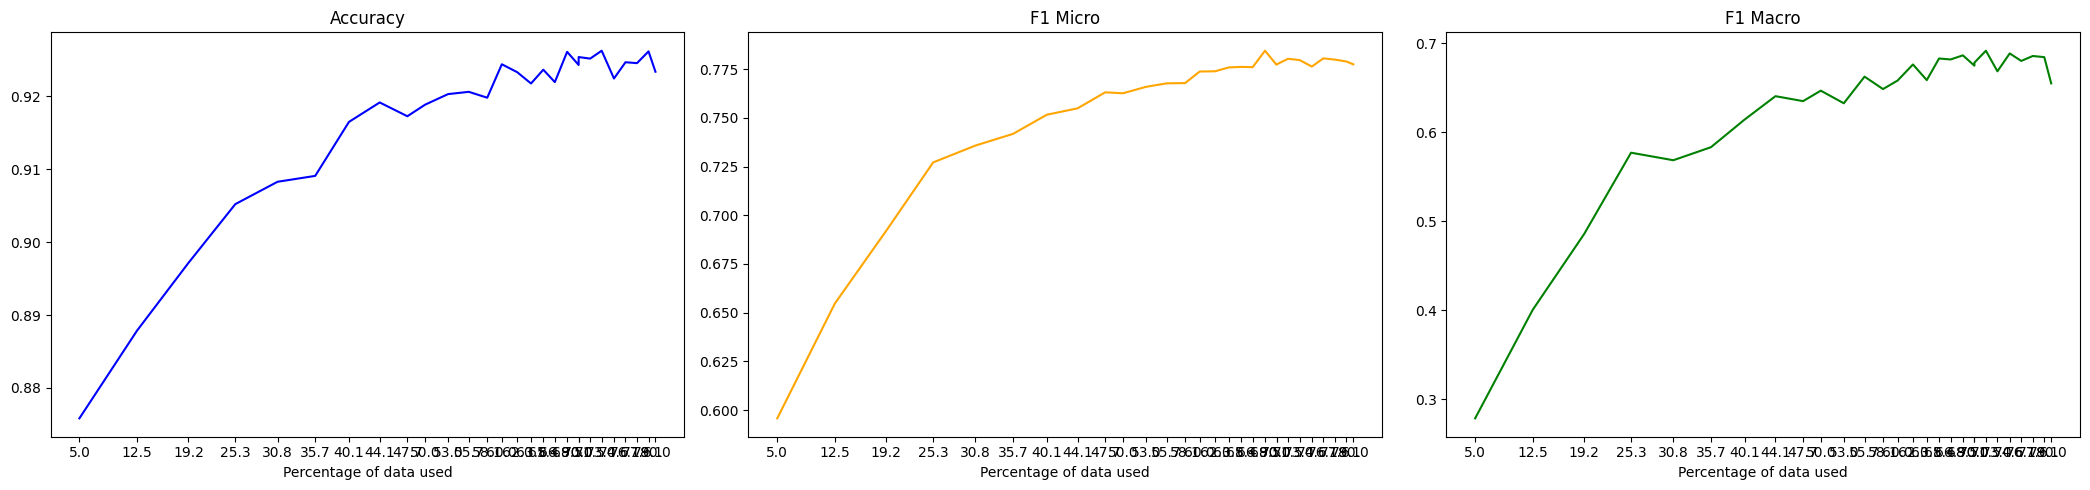

In [23]:
active_learning(seeds[1], 1)

## RUN 3

TRIAL 3
Random seed: 14
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.594, Accuracy: 0.8303, F1 Micro: 0.15, F1 Macro: 0.0437
Epoch 2/10, Train Loss: 0.4652, Accuracy: 0.8285, F1 Micro: 0.0416, F1 Macro: 0.0152
Epoch 3/10, Train Loss: 0.4094, Accuracy: 0.8364, F1 Micro: 0.1398, F1 Macro: 0.0501
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3926, Accuracy: 0.8436, F1 Micro: 0.2235, F1 Macro: 0.0794
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3791, Accuracy: 0.8477, F1 Micro: 0.2776, F1 Macro: 0.0938
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3608, Accuracy: 0.8576, F1 Micro: 0.4092, F1 Macro: 0.1411
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3392, Accuracy: 0.8662, F1 Micro: 0.4501, F1 Macro: 0.1988
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3049, Accuracy: 0.8748, F1 Micro: 0.5479, F1 Macro: 0.2676
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.289, Accuracy: 0.8755, F1 Micro: 0.6283, F1 Macro: 0.3309
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5168, Accuracy: 0.8277, F1 Micro: 0.0145, F1 Macro: 0.0058
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3853, Accuracy: 0.8306, F1 Micro: 0.0477, F1 Macro: 0.0201
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3538, Accuracy: 0.8542, F1 Micro: 0.3653, F1 Macro: 0.1135
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3303, Accuracy: 0.8761, F1 Micro: 0.5625, F1 Macro: 0.2598
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2961, Accuracy: 0.8808, F1 Micro: 0.5638, F1 Macro: 0.273
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2595, Accuracy: 0.89, F1 Micro: 0.6483, F1 Macro: 0.3479
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2283, Accuracy: 0.8951, F1 Micro: 0.6653, F1 Macro: 0.3885
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2093, Accuracy: 0.8969, F1 Micro: 0.6712, F1 Macro: 0.4077
Epoch 9/10, Train Loss: 0.1895, Accuracy: 0.898, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4738, Accuracy: 0.829, F1 Micro: 0.0282, F1 Macro: 0.012
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.362, Accuracy: 0.8532, F1 Micro: 0.3415, F1 Macro: 0.1106
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3286, Accuracy: 0.879, F1 Micro: 0.5914, F1 Macro: 0.2818
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.29, Accuracy: 0.8912, F1 Micro: 0.6567, F1 Macro: 0.3578
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2482, Accuracy: 0.8975, F1 Micro: 0.6687, F1 Macro: 0.4162
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2064, Accuracy: 0.9022, F1 Micro: 0.6921, F1 Macro: 0.4419
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1801, Accuracy: 0.9052, F1 Micro: 0.6971, F1 Macro: 0.4511
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1589, Accuracy: 0.9067, F1 Micro: 0.7063, F1 Macro: 0.506
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1436

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4511, Accuracy: 0.834, F1 Micro: 0.0953, F1 Macro: 0.0376
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3567, Accuracy: 0.8762, F1 Micro: 0.5532, F1 Macro: 0.2504
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3029, Accuracy: 0.893, F1 Micro: 0.653, F1 Macro: 0.3601
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2577, Accuracy: 0.9, F1 Micro: 0.7079, F1 Macro: 0.471
Epoch 5/10, Train Loss: 0.2292, Accuracy: 0.9058, F1 Micro: 0.7045, F1 Macro: 0.4754
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1901, Accuracy: 0.9096, F1 Micro: 0.7398, F1 Macro: 0.5364
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1618, Accuracy: 0.9119, F1 Micro: 0.7424, F1 Macro: 0.5451
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1406, Accuracy: 0.9143, F1 Micro: 0.7508, F1 Macro: 0.5725
Epoch 9/10, Train Loss: 0.1202, Accuracy: 0.9129, F1 Micro: 0.7502, F1 Macro: 0.5681
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4389, Accuracy: 0.8437, F1 Micro: 0.2183, F1 Macro: 0.0776
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3451, Accuracy: 0.8809, F1 Micro: 0.5735, F1 Macro: 0.2779
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.285, Accuracy: 0.8971, F1 Micro: 0.6663, F1 Macro: 0.4048
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2511, Accuracy: 0.9046, F1 Micro: 0.6979, F1 Macro: 0.4614
Epoch 5/10, Train Loss: 0.2091, Accuracy: 0.9057, F1 Micro: 0.6782, F1 Macro: 0.48
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1847, Accuracy: 0.9075, F1 Micro: 0.7404, F1 Macro: 0.5418
Epoch 7/10, Train Loss: 0.159, Accuracy: 0.9135, F1 Micro: 0.73, F1 Macro: 0.5305
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1305, Accuracy: 0.9152, F1 Micro: 0.7451, F1 Macro: 0.5773
Epoch 9/10, Train Loss: 0.1128, Accuracy: 0.9157, F1 Micro: 0.7402, F1 Macro: 0.5821
Higher F1 achieved, saving model
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4307, Accuracy: 0.8469, F1 Micro: 0.261, F1 Macro: 0.0896
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3328, Accuracy: 0.8871, F1 Micro: 0.6262, F1 Macro: 0.3233
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2755, Accuracy: 0.9031, F1 Micro: 0.7083, F1 Macro: 0.4604
Epoch 4/10, Train Loss: 0.2312, Accuracy: 0.9091, F1 Micro: 0.7056, F1 Macro: 0.5019
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2039, Accuracy: 0.9138, F1 Micro: 0.7356, F1 Macro: 0.5689
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1704, Accuracy: 0.918, F1 Micro: 0.7563, F1 Macro: 0.5755
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1498, Accuracy: 0.9192, F1 Micro: 0.7585, F1 Macro: 0.5853
Epoch 8/10, Train Loss: 0.1238, Accuracy: 0.9094, F1 Micro: 0.7539, F1 Macro: 0.5901
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1067, Accuracy: 0.9182, F1 Micro: 0.7612, F1 Macro: 0.6179
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4202, Accuracy: 0.8493, F1 Micro: 0.2724, F1 Macro: 0.0926
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3187, Accuracy: 0.8897, F1 Micro: 0.6132, F1 Macro: 0.3214
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2642, Accuracy: 0.9042, F1 Micro: 0.6982, F1 Macro: 0.4547
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2277, Accuracy: 0.9127, F1 Micro: 0.7266, F1 Macro: 0.5231
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1934, Accuracy: 0.9146, F1 Micro: 0.7357, F1 Macro: 0.5426
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1677, Accuracy: 0.9204, F1 Micro: 0.7625, F1 Macro: 0.5878
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1402, Accuracy: 0.9207, F1 Micro: 0.7655, F1 Macro: 0.5912
Epoch 8/10, Train Loss: 0.117, Accuracy: 0.92, F1 Micro: 0.7603, F1 Macro: 0.6168
Epoch 9/10, Train Loss: 0.1024, Accuracy: 0.9203, F1 Micro: 0.7643, F1 Macro: 0.6081
Higher 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4166, Accuracy: 0.8622, F1 Micro: 0.4239, F1 Macro: 0.1488
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3148, Accuracy: 0.8961, F1 Micro: 0.6795, F1 Macro: 0.4009
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2585, Accuracy: 0.9083, F1 Micro: 0.7219, F1 Macro: 0.5173
Epoch 4/10, Train Loss: 0.2149, Accuracy: 0.9138, F1 Micro: 0.7188, F1 Macro: 0.5378
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1825, Accuracy: 0.9192, F1 Micro: 0.7563, F1 Macro: 0.5787
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1557, Accuracy: 0.9195, F1 Micro: 0.7642, F1 Macro: 0.5991
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1211, Accuracy: 0.9227, F1 Micro: 0.7653, F1 Macro: 0.5956
Epoch 8/10, Train Loss: 0.1139, Accuracy: 0.9218, F1 Micro: 0.7627, F1 Macro: 0.6165
Epoch 9/10, Train Loss: 0.0969, Accuracy: 0.9215, F1 Micro: 0.7646, F1 Macro: 0.6214
Higher F1 achieved, saving model
Epoc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4116, Accuracy: 0.8721, F1 Micro: 0.5175, F1 Macro: 0.224
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3022, Accuracy: 0.899, F1 Micro: 0.6716, F1 Macro: 0.416
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2526, Accuracy: 0.9079, F1 Micro: 0.708, F1 Macro: 0.4489
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2105, Accuracy: 0.9165, F1 Micro: 0.7389, F1 Macro: 0.5455
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.178, Accuracy: 0.9207, F1 Micro: 0.7614, F1 Macro: 0.5877
Epoch 6/10, Train Loss: 0.1495, Accuracy: 0.9207, F1 Micro: 0.7582, F1 Macro: 0.6011
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1247, Accuracy: 0.92, F1 Micro: 0.7666, F1 Macro: 0.6117
Epoch 8/10, Train Loss: 0.106, Accuracy: 0.9209, F1 Micro: 0.7589, F1 Macro: 0.6303
Epoch 9/10, Train Loss: 0.0912, Accuracy: 0.9229, F1 Micro: 0.7618, F1 Macro: 0.6308
Higher F1 achieved, saving model
Epoch 10/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4102, Accuracy: 0.8759, F1 Micro: 0.5735, F1 Macro: 0.2641
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2982, Accuracy: 0.8973, F1 Micro: 0.642, F1 Macro: 0.3634
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2441, Accuracy: 0.9111, F1 Micro: 0.7417, F1 Macro: 0.5425
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2113, Accuracy: 0.917, F1 Micro: 0.7447, F1 Macro: 0.5623
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1787, Accuracy: 0.9138, F1 Micro: 0.7579, F1 Macro: 0.5877
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1526, Accuracy: 0.9174, F1 Micro: 0.7683, F1 Macro: 0.603
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1286, Accuracy: 0.9222, F1 Micro: 0.7723, F1 Macro: 0.6226
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1101, Accuracy: 0.923, F1 Micro: 0.7726, F1 Macro: 0.6304
Epoch 9/10, Train Loss: 0.095, Accuracy: 0.9216, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4068, Accuracy: 0.8769, F1 Micro: 0.5598, F1 Macro: 0.2583
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2923, Accuracy: 0.9012, F1 Micro: 0.6758, F1 Macro: 0.4168
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2466, Accuracy: 0.9129, F1 Micro: 0.7377, F1 Macro: 0.5514
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2061, Accuracy: 0.9189, F1 Micro: 0.7543, F1 Macro: 0.5716
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1738, Accuracy: 0.9226, F1 Micro: 0.7707, F1 Macro: 0.6091
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1407, Accuracy: 0.9218, F1 Micro: 0.7751, F1 Macro: 0.6255
Epoch 7/10, Train Loss: 0.1246, Accuracy: 0.9242, F1 Micro: 0.7732, F1 Macro: 0.6329
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1059, Accuracy: 0.9218, F1 Micro: 0.7757, F1 Macro: 0.6522
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0911, Accuracy: 0.9224, F1 Mic

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.403, Accuracy: 0.8791, F1 Micro: 0.5906, F1 Macro: 0.2879
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2884, Accuracy: 0.9039, F1 Micro: 0.6988, F1 Macro: 0.4713
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2344, Accuracy: 0.9157, F1 Micro: 0.7477, F1 Macro: 0.5715
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2004, Accuracy: 0.9172, F1 Micro: 0.7579, F1 Macro: 0.5848
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1699, Accuracy: 0.9185, F1 Micro: 0.764, F1 Macro: 0.6085
Epoch 6/10, Train Loss: 0.1393, Accuracy: 0.9212, F1 Micro: 0.7547, F1 Macro: 0.6056
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1213, Accuracy: 0.9203, F1 Micro: 0.7726, F1 Macro: 0.6318
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1021, Accuracy: 0.9248, F1 Micro: 0.7727, F1 Macro: 0.647
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0878, Accuracy: 0.9247, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4022, Accuracy: 0.8791, F1 Micro: 0.5784, F1 Macro: 0.2758
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2826, Accuracy: 0.9057, F1 Micro: 0.703, F1 Macro: 0.4754
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2393, Accuracy: 0.9138, F1 Micro: 0.7472, F1 Macro: 0.5496
Epoch 4/10, Train Loss: 0.197, Accuracy: 0.9189, F1 Micro: 0.7406, F1 Macro: 0.5873
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1675, Accuracy: 0.9225, F1 Micro: 0.766, F1 Macro: 0.6129
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1432, Accuracy: 0.9244, F1 Micro: 0.7727, F1 Macro: 0.6203
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1215, Accuracy: 0.9262, F1 Micro: 0.779, F1 Macro: 0.6491
Epoch 8/10, Train Loss: 0.1008, Accuracy: 0.9227, F1 Micro: 0.7671, F1 Macro: 0.6379
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0875, Accuracy: 0.9258, F1 Micro: 0.7797, F1 Macro: 0.6551
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3957, Accuracy: 0.8817, F1 Micro: 0.585, F1 Macro: 0.2809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2811, Accuracy: 0.9063, F1 Micro: 0.7009, F1 Macro: 0.4839
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2356, Accuracy: 0.917, F1 Micro: 0.7341, F1 Macro: 0.5364
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1965, Accuracy: 0.9209, F1 Micro: 0.7496, F1 Macro: 0.5739
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1666, Accuracy: 0.9227, F1 Micro: 0.7762, F1 Macro: 0.6289
Epoch 6/10, Train Loss: 0.1389, Accuracy: 0.9194, F1 Micro: 0.772, F1 Macro: 0.6227
Epoch 7/10, Train Loss: 0.1179, Accuracy: 0.9249, F1 Micro: 0.773, F1 Macro: 0.6325
Epoch 8/10, Train Loss: 0.1034, Accuracy: 0.9235, F1 Micro: 0.7751, F1 Macro: 0.6392
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0859, Accuracy: 0.9248, F1 Micro: 0.7836, F1 Macro: 0.6632
Epoch 10/10, Train Loss: 0.0744, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3901, Accuracy: 0.8816, F1 Micro: 0.6005, F1 Macro: 0.2917
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.278, Accuracy: 0.9035, F1 Micro: 0.7167, F1 Macro: 0.4813
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2362, Accuracy: 0.917, F1 Micro: 0.7422, F1 Macro: 0.5629
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1936, Accuracy: 0.9195, F1 Micro: 0.7644, F1 Macro: 0.592
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1633, Accuracy: 0.9236, F1 Micro: 0.7699, F1 Macro: 0.6232
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1374, Accuracy: 0.925, F1 Micro: 0.777, F1 Macro: 0.6218
Epoch 7/10, Train Loss: 0.1177, Accuracy: 0.9256, F1 Micro: 0.7754, F1 Macro: 0.6346
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.101, Accuracy: 0.924, F1 Micro: 0.7778, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0796, Accuracy: 0.9256, F1 Micro: 0.77

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3877, Accuracy: 0.8819, F1 Micro: 0.618, F1 Macro: 0.2976
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.283, Accuracy: 0.9055, F1 Micro: 0.6812, F1 Macro: 0.4432
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2308, Accuracy: 0.9152, F1 Micro: 0.7496, F1 Macro: 0.5833
Epoch 4/10, Train Loss: 0.1893, Accuracy: 0.9184, F1 Micro: 0.7352, F1 Macro: 0.5648
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1669, Accuracy: 0.9228, F1 Micro: 0.776, F1 Macro: 0.6233
Epoch 6/10, Train Loss: 0.1386, Accuracy: 0.9197, F1 Micro: 0.7742, F1 Macro: 0.6359
Epoch 7/10, Train Loss: 0.1151, Accuracy: 0.924, F1 Micro: 0.7736, F1 Macro: 0.6291
Epoch 8/10, Train Loss: 0.1004, Accuracy: 0.9243, F1 Micro: 0.776, F1 Macro: 0.6542
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0826, Accuracy: 0.9231, F1 Micro: 0.7776, F1 Macro: 0.657
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0733, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3884, Accuracy: 0.8837, F1 Micro: 0.6001, F1 Macro: 0.2999
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2752, Accuracy: 0.9072, F1 Micro: 0.7305, F1 Macro: 0.5339
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2255, Accuracy: 0.9186, F1 Micro: 0.7451, F1 Macro: 0.5483
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1896, Accuracy: 0.9209, F1 Micro: 0.76, F1 Macro: 0.6001
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1599, Accuracy: 0.9241, F1 Micro: 0.7798, F1 Macro: 0.6277
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1308, Accuracy: 0.9248, F1 Micro: 0.782, F1 Macro: 0.6442
Epoch 7/10, Train Loss: 0.1134, Accuracy: 0.9241, F1 Micro: 0.77, F1 Macro: 0.6353
Epoch 8/10, Train Loss: 0.0977, Accuracy: 0.9235, F1 Micro: 0.7793, F1 Macro: 0.6605
Epoch 9/10, Train Loss: 0.0801, Accuracy: 0.9219, F1 Micro: 0.7775, F1 Macro: 0.6577
Epoch 10/10, Train Loss: 0.0723, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3907, Accuracy: 0.8853, F1 Micro: 0.6256, F1 Macro: 0.3255
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2706, Accuracy: 0.9093, F1 Micro: 0.7252, F1 Macro: 0.5213
Epoch 3/10, Train Loss: 0.223, Accuracy: 0.9136, F1 Micro: 0.7145, F1 Macro: 0.5345
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1904, Accuracy: 0.9228, F1 Micro: 0.7607, F1 Macro: 0.5811
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1601, Accuracy: 0.9264, F1 Micro: 0.7762, F1 Macro: 0.6125
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1353, Accuracy: 0.9278, F1 Micro: 0.7834, F1 Macro: 0.6397
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1148, Accuracy: 0.9285, F1 Micro: 0.7851, F1 Macro: 0.6509
Epoch 8/10, Train Loss: 0.095, Accuracy: 0.9264, F1 Micro: 0.7805, F1 Macro: 0.6578
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0812, Accuracy: 0.9278, F1 Micro: 0.7882, F1 Macro: 0.6904
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.383, Accuracy: 0.8824, F1 Micro: 0.5624, F1 Macro: 0.2781
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2653, Accuracy: 0.9078, F1 Micro: 0.7268, F1 Macro: 0.5036
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2236, Accuracy: 0.919, F1 Micro: 0.7509, F1 Macro: 0.5751
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1864, Accuracy: 0.9233, F1 Micro: 0.7669, F1 Macro: 0.6105
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1582, Accuracy: 0.9226, F1 Micro: 0.779, F1 Macro: 0.6392
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1329, Accuracy: 0.9261, F1 Micro: 0.7798, F1 Macro: 0.6494
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1119, Accuracy: 0.9248, F1 Micro: 0.7813, F1 Macro: 0.6508
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0974, Accuracy: 0.926, F1 Micro: 0.7856, F1 Macro: 0.6799
Epoch 9/10, Train Loss: 0.0812, Accuracy: 0.9257, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3883, Accuracy: 0.8879, F1 Micro: 0.6347, F1 Macro: 0.3338
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2666, Accuracy: 0.9069, F1 Micro: 0.6784, F1 Macro: 0.4437
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2186, Accuracy: 0.9196, F1 Micro: 0.7591, F1 Macro: 0.5849
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1856, Accuracy: 0.9198, F1 Micro: 0.7689, F1 Macro: 0.6147
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1549, Accuracy: 0.9262, F1 Micro: 0.7805, F1 Macro: 0.6367
Epoch 6/10, Train Loss: 0.1347, Accuracy: 0.9277, F1 Micro: 0.7791, F1 Macro: 0.6323
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1111, Accuracy: 0.9258, F1 Micro: 0.7868, F1 Macro: 0.6487
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0964, Accuracy: 0.9283, F1 Micro: 0.7868, F1 Macro: 0.6734
Epoch 9/10, Train Loss: 0.0811, Accuracy: 0.9265, F1 Micro: 0.7865, F1 Macro: 0.6917
Epoc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3823, Accuracy: 0.8863, F1 Micro: 0.6299, F1 Macro: 0.3219
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2699, Accuracy: 0.9089, F1 Micro: 0.7008, F1 Macro: 0.5083
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2177, Accuracy: 0.9188, F1 Micro: 0.7588, F1 Macro: 0.5823
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1797, Accuracy: 0.9244, F1 Micro: 0.7767, F1 Macro: 0.6163
Epoch 5/10, Train Loss: 0.1554, Accuracy: 0.9248, F1 Micro: 0.7733, F1 Macro: 0.6251
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.13, Accuracy: 0.9288, F1 Micro: 0.787, F1 Macro: 0.6656
Epoch 7/10, Train Loss: 0.1071, Accuracy: 0.9287, F1 Micro: 0.7797, F1 Macro: 0.6433
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.098, Accuracy: 0.9257, F1 Micro: 0.7873, F1 Macro: 0.6684
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0815, Accuracy: 0.9283, F1 Micro: 0.7919, F1 Macro: 0.6903
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3848, Accuracy: 0.8828, F1 Micro: 0.5597, F1 Macro: 0.2733
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2638, Accuracy: 0.9114, F1 Micro: 0.7386, F1 Macro: 0.5331
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2179, Accuracy: 0.9198, F1 Micro: 0.7569, F1 Macro: 0.582
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1837, Accuracy: 0.9224, F1 Micro: 0.7721, F1 Macro: 0.6016
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1534, Accuracy: 0.925, F1 Micro: 0.781, F1 Macro: 0.6365
Epoch 6/10, Train Loss: 0.1278, Accuracy: 0.9271, F1 Micro: 0.7809, F1 Macro: 0.6375
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1069, Accuracy: 0.9264, F1 Micro: 0.7818, F1 Macro: 0.6554
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0922, Accuracy: 0.9257, F1 Micro: 0.7849, F1 Macro: 0.6793
Epoch 9/10, Train Loss: 0.0779, Accuracy: 0.9255, F1 Micro: 0.7833, F1 Macro: 0.6929
Higher 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3798, Accuracy: 0.8903, F1 Micro: 0.6354, F1 Macro: 0.3343
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.26, Accuracy: 0.9113, F1 Micro: 0.7226, F1 Macro: 0.5067
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.214, Accuracy: 0.9182, F1 Micro: 0.767, F1 Macro: 0.599
Epoch 4/10, Train Loss: 0.1829, Accuracy: 0.9192, F1 Micro: 0.7669, F1 Macro: 0.6147
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1524, Accuracy: 0.9245, F1 Micro: 0.7749, F1 Macro: 0.6323
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1292, Accuracy: 0.9269, F1 Micro: 0.783, F1 Macro: 0.6418
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1104, Accuracy: 0.9252, F1 Micro: 0.7836, F1 Macro: 0.6909
Epoch 8/10, Train Loss: 0.0938, Accuracy: 0.9273, F1 Micro: 0.7815, F1 Macro: 0.6812
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0764, Accuracy: 0.9273, F1 Micro: 0.79, F1 Macro: 0.6977
Epoch 10/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3782, Accuracy: 0.8901, F1 Micro: 0.6417, F1 Macro: 0.3563
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2645, Accuracy: 0.9089, F1 Micro: 0.7062, F1 Macro: 0.4393
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2141, Accuracy: 0.9219, F1 Micro: 0.762, F1 Macro: 0.5925
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.181, Accuracy: 0.9245, F1 Micro: 0.7726, F1 Macro: 0.6242
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.153, Accuracy: 0.9266, F1 Micro: 0.7821, F1 Macro: 0.6444
Epoch 6/10, Train Loss: 0.1293, Accuracy: 0.9238, F1 Micro: 0.7804, F1 Macro: 0.6568
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1092, Accuracy: 0.9284, F1 Micro: 0.7862, F1 Macro: 0.6776
Epoch 8/10, Train Loss: 0.0919, Accuracy: 0.9258, F1 Micro: 0.784, F1 Macro: 0.6789
Epoch 9/10, Train Loss: 0.0716, Accuracy: 0.9249, F1 Micro: 0.7834, F1 Macro: 0.6815
Higher F1 achieved, saving model
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3772, Accuracy: 0.8912, F1 Micro: 0.6592, F1 Macro: 0.3756
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.253, Accuracy: 0.9128, F1 Micro: 0.7368, F1 Macro: 0.5301
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.214, Accuracy: 0.9212, F1 Micro: 0.7664, F1 Macro: 0.6052
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1726, Accuracy: 0.924, F1 Micro: 0.7735, F1 Macro: 0.6176
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1488, Accuracy: 0.9271, F1 Micro: 0.7858, F1 Macro: 0.6455
Epoch 6/10, Train Loss: 0.1245, Accuracy: 0.9285, F1 Micro: 0.7854, F1 Macro: 0.6631
Epoch 7/10, Train Loss: 0.1016, Accuracy: 0.9263, F1 Micro: 0.7841, F1 Macro: 0.6567
Epoch 8/10, Train Loss: 0.0882, Accuracy: 0.9278, F1 Micro: 0.78, F1 Macro: 0.6866
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0787, Accuracy: 0.9286, F1 Micro: 0.7921, F1 Macro: 0.6824
Higher F1 achieved, saving model
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3761, Accuracy: 0.8882, F1 Micro: 0.6051, F1 Macro: 0.2977
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.256, Accuracy: 0.9124, F1 Micro: 0.7231, F1 Macro: 0.5215
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2061, Accuracy: 0.9194, F1 Micro: 0.7666, F1 Macro: 0.6068
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1745, Accuracy: 0.9185, F1 Micro: 0.7727, F1 Macro: 0.6282
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.147, Accuracy: 0.9258, F1 Micro: 0.7834, F1 Macro: 0.6421
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1208, Accuracy: 0.9299, F1 Micro: 0.7892, F1 Macro: 0.6618
Epoch 7/10, Train Loss: 0.1036, Accuracy: 0.9277, F1 Micro: 0.7875, F1 Macro: 0.6736
Epoch 8/10, Train Loss: 0.086, Accuracy: 0.9269, F1 Micro: 0.7863, F1 Macro: 0.6831
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0753, Accuracy: 0.928, F1 Micro: 0.7911, F1 Macro: 0.7115
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3664, Accuracy: 0.8854, F1 Micro: 0.568, F1 Macro: 0.2922
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.248, Accuracy: 0.9114, F1 Micro: 0.7275, F1 Macro: 0.5154
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2071, Accuracy: 0.9219, F1 Micro: 0.7656, F1 Macro: 0.5973
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1735, Accuracy: 0.9257, F1 Micro: 0.78, F1 Macro: 0.6281
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1439, Accuracy: 0.9286, F1 Micro: 0.7869, F1 Macro: 0.6403
Epoch 6/10, Train Loss: 0.1164, Accuracy: 0.9295, F1 Micro: 0.7842, F1 Macro: 0.6544
Epoch 7/10, Train Loss: 0.0998, Accuracy: 0.9216, F1 Micro: 0.7795, F1 Macro: 0.6738
Epoch 8/10, Train Loss: 0.0867, Accuracy: 0.926, F1 Micro: 0.7808, F1 Macro: 0.6817
Epoch 9/10, Train Loss: 0.075, Accuracy: 0.9235, F1 Micro: 0.7843, F1 Macro: 0.6895
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0659, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3592, Accuracy: 0.8915, F1 Micro: 0.6214, F1 Macro: 0.3275
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2444, Accuracy: 0.9123, F1 Micro: 0.7389, F1 Macro: 0.5517
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2009, Accuracy: 0.9207, F1 Micro: 0.7635, F1 Macro: 0.5951
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.17, Accuracy: 0.9234, F1 Micro: 0.7773, F1 Macro: 0.6336
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.14, Accuracy: 0.9228, F1 Micro: 0.7812, F1 Macro: 0.6248
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1196, Accuracy: 0.9306, F1 Micro: 0.7923, F1 Macro: 0.6562
Epoch 7/10, Train Loss: 0.0979, Accuracy: 0.9264, F1 Micro: 0.7869, F1 Macro: 0.6956
Epoch 8/10, Train Loss: 0.0823, Accuracy: 0.9289, F1 Micro: 0.7902, F1 Macro: 0.6971
Epoch 9/10, Train Loss: 0.0737, Accuracy: 0.9299, F1 Micro: 0.7922, F1 Macro: 0.7115
Epoch 10/10, Train Loss: 0.0622, Accuracy

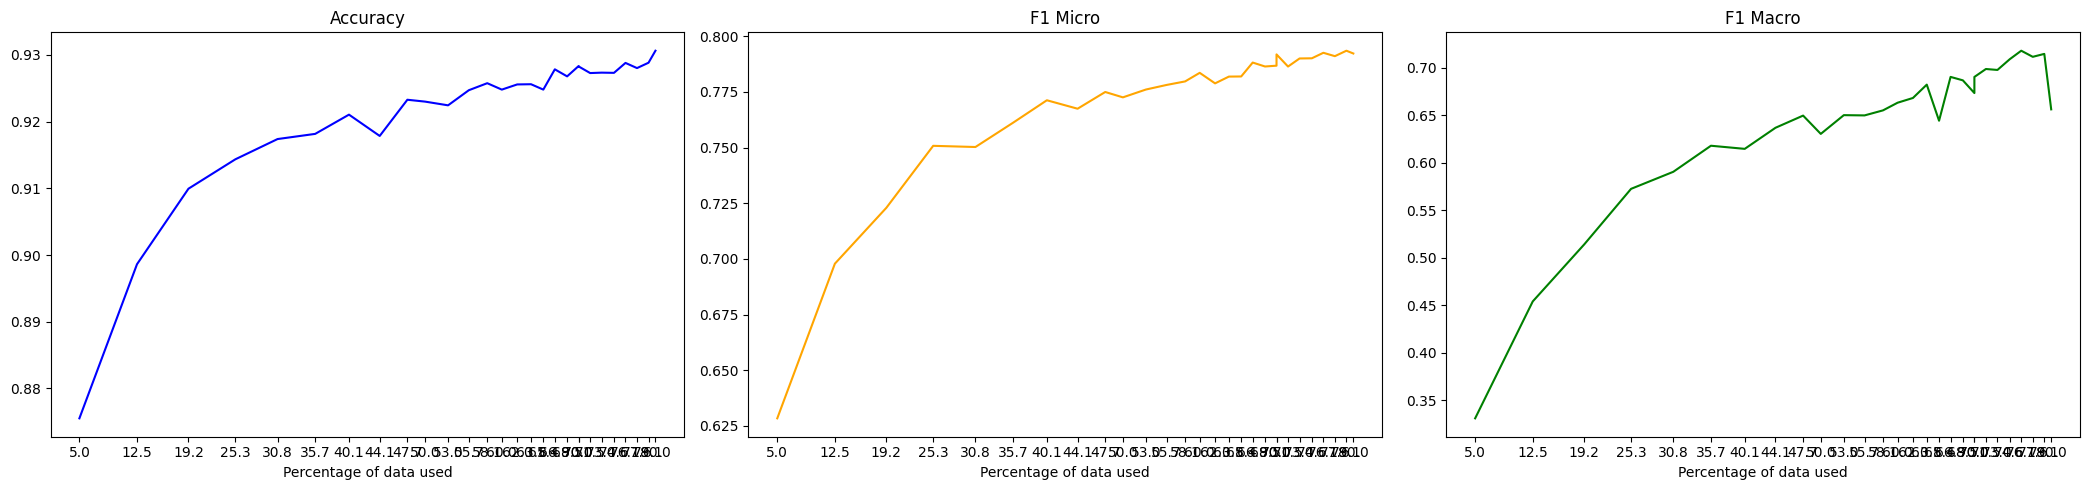

In [ ]:
active_learning(seeds[2], 2)

## RUN 4

TRIAL 4
Random seed: 3
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6126, Accuracy: 0.8292, F1 Micro: 0.1246, F1 Macro: 0.0417
Epoch 2/10, Train Loss: 0.466, Accuracy: 0.8283, F1 Micro: 0.0135, F1 Macro: 0.006
Epoch 3/10, Train Loss: 0.4052, Accuracy: 0.8326, F1 Micro: 0.0744, F1 Macro: 0.0285
Epoch 4/10, Train Loss: 0.3854, Accuracy: 0.8366, F1 Micro: 0.1202, F1 Macro: 0.0461
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3789, Accuracy: 0.846, F1 Micro: 0.2352, F1 Macro: 0.0831
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.367, Accuracy: 0.8566, F1 Micro: 0.3727, F1 Macro: 0.1226
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3376, Accuracy: 0.8669, F1 Micro: 0.4634, F1 Macro: 0.2008
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3093, Accuracy: 0.8723, F1 Micro: 0.5046, F1 Macro: 0.2333
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2958, Accuracy: 0.875, F1 Micro: 0.5295, F1 Macro: 0.2488
Higher F1 achieved, saving model
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5406, Accuracy: 0.828, F1 Micro: 0.0057, F1 Macro: 0.0026
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3917, Accuracy: 0.8298, F1 Micro: 0.0269, F1 Macro: 0.0118
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3657, Accuracy: 0.8375, F1 Micro: 0.1333, F1 Macro: 0.0483
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3401, Accuracy: 0.8626, F1 Micro: 0.4042, F1 Macro: 0.1729
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3224, Accuracy: 0.873, F1 Micro: 0.621, F1 Macro: 0.2866
Epoch 6/10, Train Loss: 0.2989, Accuracy: 0.881, F1 Micro: 0.5471, F1 Macro: 0.2551
Epoch 7/10, Train Loss: 0.2579, Accuracy: 0.8878, F1 Micro: 0.6127, F1 Macro: 0.3101
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2334, Accuracy: 0.8899, F1 Micro: 0.6504, F1 Macro: 0.3659
Epoch 9/10, Train Loss: 0.2059, Accuracy: 0.8878, F1 Micro: 0.5972, F1 Macro: 0.3591
Higher F1 achieved, saving model
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4892, Accuracy: 0.8331, F1 Micro: 0.0988, F1 Macro: 0.0349
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3747, Accuracy: 0.8466, F1 Micro: 0.2573, F1 Macro: 0.0868
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3433, Accuracy: 0.8787, F1 Micro: 0.5745, F1 Macro: 0.2674
Epoch 4/10, Train Loss: 0.3045, Accuracy: 0.8826, F1 Micro: 0.5544, F1 Macro: 0.2528
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2638, Accuracy: 0.8915, F1 Micro: 0.63, F1 Macro: 0.336
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2264, Accuracy: 0.8935, F1 Micro: 0.6773, F1 Macro: 0.4224
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2015, Accuracy: 0.8935, F1 Micro: 0.6929, F1 Macro: 0.4623
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1816, Accuracy: 0.9, F1 Micro: 0.6937, F1 Macro: 0.4905
Epoch 9/10, Train Loss: 0.1557, Accuracy: 0.9001, F1 Micro: 0.6818, F1 Macro: 0.4903
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4639, Accuracy: 0.8323, F1 Micro: 0.0806, F1 Macro: 0.03
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3693, Accuracy: 0.8646, F1 Micro: 0.4221, F1 Macro: 0.1769
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3151, Accuracy: 0.885, F1 Micro: 0.5944, F1 Macro: 0.2799
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2752, Accuracy: 0.8934, F1 Micro: 0.6599, F1 Macro: 0.3773
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.226, Accuracy: 0.8957, F1 Micro: 0.6861, F1 Macro: 0.4713
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1936, Accuracy: 0.9039, F1 Micro: 0.6929, F1 Macro: 0.5044
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1674, Accuracy: 0.9037, F1 Micro: 0.7125, F1 Macro: 0.5373
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.141, Accuracy: 0.9067, F1 Micro: 0.7171, F1 Macro: 0.5399
Epoch 9/10, Train Loss: 0.1223, Accuracy: 0.9077, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4508, Accuracy: 0.8344, F1 Micro: 0.104, F1 Macro: 0.037
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.351, Accuracy: 0.8808, F1 Micro: 0.5831, F1 Macro: 0.2702
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2921, Accuracy: 0.8899, F1 Micro: 0.6474, F1 Macro: 0.3458
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2481, Accuracy: 0.8956, F1 Micro: 0.6938, F1 Macro: 0.45
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2144, Accuracy: 0.9021, F1 Micro: 0.7018, F1 Macro: 0.5075
Epoch 6/10, Train Loss: 0.1832, Accuracy: 0.9042, F1 Micro: 0.6921, F1 Macro: 0.5126
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1578, Accuracy: 0.9079, F1 Micro: 0.7115, F1 Macro: 0.5335
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1342, Accuracy: 0.9092, F1 Micro: 0.7296, F1 Macro: 0.5577
Epoch 9/10, Train Loss: 0.1138, Accuracy: 0.9105, F1 Micro: 0.7209, F1 Macro: 0.565
Higher F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4369, Accuracy: 0.8397, F1 Micro: 0.1873, F1 Macro: 0.0585
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3468, Accuracy: 0.8819, F1 Micro: 0.5923, F1 Macro: 0.2735
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.288, Accuracy: 0.8925, F1 Micro: 0.6086, F1 Macro: 0.3383
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2375, Accuracy: 0.9004, F1 Micro: 0.6771, F1 Macro: 0.4273
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2049, Accuracy: 0.9033, F1 Micro: 0.7233, F1 Macro: 0.5391
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1771, Accuracy: 0.9068, F1 Micro: 0.7327, F1 Macro: 0.5517
Epoch 7/10, Train Loss: 0.146, Accuracy: 0.9107, F1 Micro: 0.731, F1 Macro: 0.5556
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1259, Accuracy: 0.9134, F1 Micro: 0.7427, F1 Macro: 0.5847
Epoch 9/10, Train Loss: 0.1074, Accuracy: 0.915, F1 Micro: 0.7411, F1 Macro: 0.5915
Higher F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4289, Accuracy: 0.8481, F1 Micro: 0.2628, F1 Macro: 0.0902
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3238, Accuracy: 0.8862, F1 Micro: 0.6303, F1 Macro: 0.3105
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2655, Accuracy: 0.8987, F1 Micro: 0.679, F1 Macro: 0.4456
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2237, Accuracy: 0.9045, F1 Micro: 0.7209, F1 Macro: 0.533
Epoch 5/10, Train Loss: 0.1937, Accuracy: 0.9103, F1 Micro: 0.7082, F1 Macro: 0.5381
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1635, Accuracy: 0.9126, F1 Micro: 0.7339, F1 Macro: 0.5554
Epoch 7/10, Train Loss: 0.1419, Accuracy: 0.908, F1 Micro: 0.7301, F1 Macro: 0.5747
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.114, Accuracy: 0.9142, F1 Micro: 0.7494, F1 Macro: 0.6112
Epoch 9/10, Train Loss: 0.1007, Accuracy: 0.916, F1 Micro: 0.7475, F1 Macro: 0.6223
Epoch 10/10, Train Loss: 0.0857, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4269, Accuracy: 0.8567, F1 Micro: 0.3478, F1 Macro: 0.1172
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3144, Accuracy: 0.89, F1 Micro: 0.6282, F1 Macro: 0.326
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2606, Accuracy: 0.9, F1 Micro: 0.6903, F1 Macro: 0.4452
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2182, Accuracy: 0.9089, F1 Micro: 0.7101, F1 Macro: 0.5087
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1906, Accuracy: 0.9131, F1 Micro: 0.7385, F1 Macro: 0.5556
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1538, Accuracy: 0.9127, F1 Micro: 0.7414, F1 Macro: 0.5711
Epoch 7/10, Train Loss: 0.1308, Accuracy: 0.9155, F1 Micro: 0.7406, F1 Macro: 0.5955
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1109, Accuracy: 0.9161, F1 Micro: 0.7428, F1 Macro: 0.6105
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0945, Accuracy: 0.9168, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4229, Accuracy: 0.8532, F1 Micro: 0.329, F1 Macro: 0.1108
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3092, Accuracy: 0.892, F1 Micro: 0.6487, F1 Macro: 0.3522
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2501, Accuracy: 0.9011, F1 Micro: 0.6916, F1 Macro: 0.4455
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2127, Accuracy: 0.9113, F1 Micro: 0.7263, F1 Macro: 0.5371
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1806, Accuracy: 0.9137, F1 Micro: 0.7273, F1 Macro: 0.5552
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1502, Accuracy: 0.9147, F1 Micro: 0.7431, F1 Macro: 0.5666
Epoch 7/10, Train Loss: 0.1313, Accuracy: 0.9156, F1 Micro: 0.7297, F1 Macro: 0.5477
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1103, Accuracy: 0.9181, F1 Micro: 0.7521, F1 Macro: 0.6248
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0941, Accuracy: 0.9166, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4214, Accuracy: 0.8678, F1 Micro: 0.4617, F1 Macro: 0.1839
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3044, Accuracy: 0.8934, F1 Micro: 0.6709, F1 Macro: 0.389
Epoch 3/10, Train Loss: 0.2479, Accuracy: 0.9023, F1 Micro: 0.664, F1 Macro: 0.4523
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2112, Accuracy: 0.9105, F1 Micro: 0.7321, F1 Macro: 0.5278
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1852, Accuracy: 0.9119, F1 Micro: 0.7423, F1 Macro: 0.5618
Epoch 6/10, Train Loss: 0.151, Accuracy: 0.9156, F1 Micro: 0.7293, F1 Macro: 0.57
Epoch 7/10, Train Loss: 0.1296, Accuracy: 0.916, F1 Micro: 0.7406, F1 Macro: 0.5926
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1064, Accuracy: 0.9167, F1 Micro: 0.7603, F1 Macro: 0.6278
Epoch 9/10, Train Loss: 0.0896, Accuracy: 0.9173, F1 Micro: 0.7528, F1 Macro: 0.6258
Epoch 10/10, Train Loss: 0.0851, Accuracy: 0.9138, F1 Micro: 0.7546, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.417, Accuracy: 0.8772, F1 Micro: 0.5752, F1 Macro: 0.2621
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2981, Accuracy: 0.8956, F1 Micro: 0.6814, F1 Macro: 0.4212
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2454, Accuracy: 0.9053, F1 Micro: 0.6882, F1 Macro: 0.4603
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2082, Accuracy: 0.9137, F1 Micro: 0.734, F1 Macro: 0.5517
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.178, Accuracy: 0.9154, F1 Micro: 0.7371, F1 Macro: 0.5558
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.149, Accuracy: 0.9158, F1 Micro: 0.7494, F1 Macro: 0.5979
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1219, Accuracy: 0.9154, F1 Micro: 0.7559, F1 Macro: 0.6408
Epoch 8/10, Train Loss: 0.1049, Accuracy: 0.9196, F1 Micro: 0.7549, F1 Macro: 0.63
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0865, Accuracy: 0.9177, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4147, Accuracy: 0.8757, F1 Micro: 0.519, F1 Macro: 0.2318
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2923, Accuracy: 0.8988, F1 Micro: 0.6768, F1 Macro: 0.4203
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.242, Accuracy: 0.9064, F1 Micro: 0.7093, F1 Macro: 0.4962
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2008, Accuracy: 0.9134, F1 Micro: 0.7435, F1 Macro: 0.5455
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1756, Accuracy: 0.9136, F1 Micro: 0.7472, F1 Macro: 0.572
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1413, Accuracy: 0.9199, F1 Micro: 0.7473, F1 Macro: 0.59
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1221, Accuracy: 0.917, F1 Micro: 0.76, F1 Macro: 0.6434
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0988, Accuracy: 0.9214, F1 Micro: 0.7629, F1 Macro: 0.6606
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0857,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4029, Accuracy: 0.8754, F1 Micro: 0.5005, F1 Macro: 0.2288
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2841, Accuracy: 0.8991, F1 Micro: 0.6702, F1 Macro: 0.4189
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.236, Accuracy: 0.9075, F1 Micro: 0.7253, F1 Macro: 0.5458
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1955, Accuracy: 0.9143, F1 Micro: 0.7474, F1 Macro: 0.5683
Epoch 5/10, Train Loss: 0.1669, Accuracy: 0.9178, F1 Micro: 0.7426, F1 Macro: 0.5665
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1434, Accuracy: 0.9188, F1 Micro: 0.7597, F1 Macro: 0.6177
Epoch 7/10, Train Loss: 0.1155, Accuracy: 0.9211, F1 Micro: 0.7591, F1 Macro: 0.6499
Epoch 8/10, Train Loss: 0.1017, Accuracy: 0.9215, F1 Micro: 0.7559, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0875, Accuracy: 0.9176, F1 Micro: 0.7649, F1 Macro: 0.6561
Epoch 10/10, Train Loss: 0.074, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4082, Accuracy: 0.8799, F1 Micro: 0.5988, F1 Macro: 0.281
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.286, Accuracy: 0.9, F1 Micro: 0.6882, F1 Macro: 0.4536
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2333, Accuracy: 0.9078, F1 Micro: 0.7293, F1 Macro: 0.5208
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1968, Accuracy: 0.915, F1 Micro: 0.7369, F1 Macro: 0.56
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.169, Accuracy: 0.9136, F1 Micro: 0.7536, F1 Macro: 0.6046
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1421, Accuracy: 0.9167, F1 Micro: 0.7663, F1 Macro: 0.6397
Epoch 7/10, Train Loss: 0.1143, Accuracy: 0.9199, F1 Micro: 0.7645, F1 Macro: 0.6494
Epoch 8/10, Train Loss: 0.0987, Accuracy: 0.9219, F1 Micro: 0.7632, F1 Macro: 0.6716
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0845, Accuracy: 0.9199, F1 Micro: 0.7689, F1 Macro: 0.6816
Epoch 10/10, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4052, Accuracy: 0.8814, F1 Micro: 0.5918, F1 Macro: 0.2743
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.285, Accuracy: 0.9, F1 Micro: 0.6992, F1 Macro: 0.4739
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2349, Accuracy: 0.9078, F1 Micro: 0.7357, F1 Macro: 0.5555
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1962, Accuracy: 0.914, F1 Micro: 0.7461, F1 Macro: 0.5659
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1585, Accuracy: 0.9186, F1 Micro: 0.7592, F1 Macro: 0.6076
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1381, Accuracy: 0.9219, F1 Micro: 0.7646, F1 Macro: 0.6363
Epoch 7/10, Train Loss: 0.1148, Accuracy: 0.9224, F1 Micro: 0.76, F1 Macro: 0.6215
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0963, Accuracy: 0.9192, F1 Micro: 0.7661, F1 Macro: 0.6641
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0844, Accuracy: 0.9205, F1 Micro: 0.7

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4029, Accuracy: 0.8787, F1 Micro: 0.5322, F1 Macro: 0.2437
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2814, Accuracy: 0.9011, F1 Micro: 0.675, F1 Macro: 0.4543
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2297, Accuracy: 0.9114, F1 Micro: 0.7225, F1 Macro: 0.5317
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1913, Accuracy: 0.9166, F1 Micro: 0.7542, F1 Macro: 0.5824
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.161, Accuracy: 0.9208, F1 Micro: 0.7563, F1 Macro: 0.5966
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1385, Accuracy: 0.922, F1 Micro: 0.7693, F1 Macro: 0.6293
Epoch 7/10, Train Loss: 0.1136, Accuracy: 0.9196, F1 Micro: 0.7521, F1 Macro: 0.6348
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0924, Accuracy: 0.9235, F1 Micro: 0.7699, F1 Macro: 0.6795
Epoch 9/10, Train Loss: 0.0831, Accuracy: 0.9214, F1 Micro: 0.7668, F1 Macro: 0.6783
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3986, Accuracy: 0.8812, F1 Micro: 0.5842, F1 Macro: 0.2734
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2834, Accuracy: 0.9032, F1 Micro: 0.6897, F1 Macro: 0.4621
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2292, Accuracy: 0.9125, F1 Micro: 0.7307, F1 Macro: 0.5497
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1958, Accuracy: 0.9126, F1 Micro: 0.7526, F1 Macro: 0.5861
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1617, Accuracy: 0.9208, F1 Micro: 0.7625, F1 Macro: 0.6079
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1366, Accuracy: 0.9197, F1 Micro: 0.765, F1 Macro: 0.6237
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1138, Accuracy: 0.921, F1 Micro: 0.7716, F1 Macro: 0.6532
Epoch 8/10, Train Loss: 0.0933, Accuracy: 0.9217, F1 Micro: 0.766, F1 Macro: 0.6724
Epoch 9/10, Train Loss: 0.0834, Accuracy: 0.9242, F1 Micro: 0.7704, F1 Macro: 0.6809
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3939, Accuracy: 0.8816, F1 Micro: 0.6187, F1 Macro: 0.2888
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2726, Accuracy: 0.9025, F1 Micro: 0.6836, F1 Macro: 0.4349
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2268, Accuracy: 0.9134, F1 Micro: 0.7255, F1 Macro: 0.5329
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1927, Accuracy: 0.918, F1 Micro: 0.7604, F1 Macro: 0.5918
Epoch 5/10, Train Loss: 0.1604, Accuracy: 0.9208, F1 Micro: 0.7597, F1 Macro: 0.6293
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1312, Accuracy: 0.918, F1 Micro: 0.7679, F1 Macro: 0.6438
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1104, Accuracy: 0.9228, F1 Micro: 0.775, F1 Macro: 0.6554
Epoch 8/10, Train Loss: 0.0931, Accuracy: 0.9196, F1 Micro: 0.7653, F1 Macro: 0.6769
Epoch 9/10, Train Loss: 0.0785, Accuracy: 0.9231, F1 Micro: 0.767, F1 Macro: 0.6896
Higher F1 achieved, saving model
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3964, Accuracy: 0.8803, F1 Micro: 0.5684, F1 Macro: 0.2693
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2698, Accuracy: 0.905, F1 Micro: 0.71, F1 Macro: 0.5052
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2253, Accuracy: 0.9131, F1 Micro: 0.7302, F1 Macro: 0.5587
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1834, Accuracy: 0.9142, F1 Micro: 0.7579, F1 Macro: 0.6007
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1579, Accuracy: 0.921, F1 Micro: 0.7676, F1 Macro: 0.6206
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1315, Accuracy: 0.9216, F1 Micro: 0.7703, F1 Macro: 0.6523
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1107, Accuracy: 0.9223, F1 Micro: 0.7717, F1 Macro: 0.6816
Epoch 8/10, Train Loss: 0.0908, Accuracy: 0.9132, F1 Micro: 0.7521, F1 Macro: 0.6589
Epoch 9/10, Train Loss: 0.0779, Accuracy: 0.924, F1 Micro: 0.7634, F1 Macro: 0.6778
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3911, Accuracy: 0.8841, F1 Micro: 0.6092, F1 Macro: 0.3019
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2662, Accuracy: 0.9046, F1 Micro: 0.7018, F1 Macro: 0.5007
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2223, Accuracy: 0.9139, F1 Micro: 0.7418, F1 Macro: 0.5772
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1824, Accuracy: 0.9125, F1 Micro: 0.7543, F1 Macro: 0.5928
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1519, Accuracy: 0.918, F1 Micro: 0.7669, F1 Macro: 0.6363
Epoch 6/10, Train Loss: 0.1301, Accuracy: 0.9221, F1 Micro: 0.7598, F1 Macro: 0.6383
Epoch 7/10, Train Loss: 0.1135, Accuracy: 0.9188, F1 Micro: 0.7658, F1 Macro: 0.673
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.092, Accuracy: 0.9198, F1 Micro: 0.7687, F1 Macro: 0.685
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0761, Accuracy: 0.9235, F1 Micro: 0.7768, F1 Macro: 0.6897
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3917, Accuracy: 0.8816, F1 Micro: 0.5618, F1 Macro: 0.2646
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2674, Accuracy: 0.9048, F1 Micro: 0.6845, F1 Macro: 0.4744
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2173, Accuracy: 0.915, F1 Micro: 0.734, F1 Macro: 0.5412
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.18, Accuracy: 0.9206, F1 Micro: 0.7559, F1 Macro: 0.6024
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1576, Accuracy: 0.9208, F1 Micro: 0.7646, F1 Macro: 0.6388
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1309, Accuracy: 0.9227, F1 Micro: 0.7754, F1 Macro: 0.6806
Epoch 7/10, Train Loss: 0.1072, Accuracy: 0.9224, F1 Micro: 0.7738, F1 Macro: 0.6647
Epoch 8/10, Train Loss: 0.092, Accuracy: 0.9231, F1 Micro: 0.7703, F1 Macro: 0.6832
Epoch 9/10, Train Loss: 0.0809, Accuracy: 0.9232, F1 Micro: 0.7729, F1 Macro: 0.6983
Higher F1 achieved, saving model
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3864, Accuracy: 0.8843, F1 Micro: 0.598, F1 Macro: 0.2957
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2655, Accuracy: 0.9044, F1 Micro: 0.6965, F1 Macro: 0.4913
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2207, Accuracy: 0.9127, F1 Micro: 0.7303, F1 Macro: 0.5517
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1853, Accuracy: 0.9195, F1 Micro: 0.7584, F1 Macro: 0.5985
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1572, Accuracy: 0.9247, F1 Micro: 0.7699, F1 Macro: 0.6349
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1302, Accuracy: 0.9232, F1 Micro: 0.7716, F1 Macro: 0.6464
Epoch 7/10, Train Loss: 0.1085, Accuracy: 0.9229, F1 Micro: 0.7702, F1 Macro: 0.6681
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0916, Accuracy: 0.9229, F1 Micro: 0.7736, F1 Macro: 0.6961
Epoch 9/10, Train Loss: 0.0762, Accuracy: 0.9246, F1 Micro: 0.7705, F1 Macro: 0.6887
Highe

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3866, Accuracy: 0.8806, F1 Micro: 0.5567, F1 Macro: 0.2649
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2714, Accuracy: 0.906, F1 Micro: 0.7116, F1 Macro: 0.4968
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2188, Accuracy: 0.9149, F1 Micro: 0.7475, F1 Macro: 0.5487
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1823, Accuracy: 0.9192, F1 Micro: 0.7476, F1 Macro: 0.5558
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1524, Accuracy: 0.9227, F1 Micro: 0.7612, F1 Macro: 0.6475
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1265, Accuracy: 0.9226, F1 Micro: 0.7713, F1 Macro: 0.6691
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1086, Accuracy: 0.9232, F1 Micro: 0.7759, F1 Macro: 0.6756
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0899, Accuracy: 0.9244, F1 Micro: 0.7767, F1 Macro: 0.6972
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3863, Accuracy: 0.8856, F1 Micro: 0.6102, F1 Macro: 0.2978
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2623, Accuracy: 0.9065, F1 Micro: 0.696, F1 Macro: 0.4985
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2156, Accuracy: 0.9169, F1 Micro: 0.7482, F1 Macro: 0.5718
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1785, Accuracy: 0.9216, F1 Micro: 0.761, F1 Macro: 0.604
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1512, Accuracy: 0.9223, F1 Micro: 0.7743, F1 Macro: 0.6707
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1256, Accuracy: 0.9219, F1 Micro: 0.7744, F1 Macro: 0.6773
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1034, Accuracy: 0.9224, F1 Micro: 0.7769, F1 Macro: 0.6949
Epoch 8/10, Train Loss: 0.0886, Accuracy: 0.9227, F1 Micro: 0.7629, F1 Macro: 0.6847
Epoch 9/10, Train Loss: 0.0772, Accuracy: 0.9254, F1 Micro: 0.7724, F1 Macro: 0.6963
Higher 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3841, Accuracy: 0.8865, F1 Micro: 0.649, F1 Macro: 0.3237
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.257, Accuracy: 0.9016, F1 Micro: 0.7212, F1 Macro: 0.5324
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2144, Accuracy: 0.9157, F1 Micro: 0.7315, F1 Macro: 0.5489
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.17, Accuracy: 0.9211, F1 Micro: 0.7573, F1 Macro: 0.6007
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1496, Accuracy: 0.9224, F1 Micro: 0.7678, F1 Macro: 0.6634
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1248, Accuracy: 0.9249, F1 Micro: 0.7742, F1 Macro: 0.6643
Epoch 7/10, Train Loss: 0.101, Accuracy: 0.9249, F1 Micro: 0.7716, F1 Macro: 0.6687
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0868, Accuracy: 0.9224, F1 Micro: 0.7745, F1 Macro: 0.6947
Epoch 9/10, Train Loss: 0.0735, Accuracy: 0.9195, F1 Micro: 0.7706, F1 Macro: 0.6929
Higher F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3837, Accuracy: 0.8877, F1 Micro: 0.6303, F1 Macro: 0.3143
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.258, Accuracy: 0.9071, F1 Micro: 0.707, F1 Macro: 0.4721
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2126, Accuracy: 0.9166, F1 Micro: 0.7376, F1 Macro: 0.5388
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1764, Accuracy: 0.9204, F1 Micro: 0.7605, F1 Macro: 0.6031
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1486, Accuracy: 0.922, F1 Micro: 0.7724, F1 Macro: 0.6349
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1214, Accuracy: 0.926, F1 Micro: 0.7758, F1 Macro: 0.6879
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1036, Accuracy: 0.9245, F1 Micro: 0.7809, F1 Macro: 0.6918
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0886, Accuracy: 0.9263, F1 Micro: 0.7822, F1 Macro: 0.7068
Epoch 9/10, Train Loss: 0.0733, Accuracy: 0.9226, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3767, Accuracy: 0.8876, F1 Micro: 0.6357, F1 Macro: 0.3426
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2533, Accuracy: 0.9031, F1 Micro: 0.7231, F1 Macro: 0.5372
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2064, Accuracy: 0.918, F1 Micro: 0.747, F1 Macro: 0.5655
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1724, Accuracy: 0.9229, F1 Micro: 0.7668, F1 Macro: 0.6176
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1449, Accuracy: 0.9252, F1 Micro: 0.7777, F1 Macro: 0.6718
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1191, Accuracy: 0.926, F1 Micro: 0.7804, F1 Macro: 0.691
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0992, Accuracy: 0.9264, F1 Micro: 0.7834, F1 Macro: 0.6964
Epoch 8/10, Train Loss: 0.083, Accuracy: 0.9208, F1 Micro: 0.7754, F1 Macro: 0.6925
Epoch 9/10, Train Loss: 0.0716, Accuracy: 0.9228, F1 Micro: 0.7763, F1 Macro: 0.7035
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.375, Accuracy: 0.8876, F1 Micro: 0.6541, F1 Macro: 0.3305
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2471, Accuracy: 0.908, F1 Micro: 0.7134, F1 Macro: 0.5203
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1998, Accuracy: 0.9168, F1 Micro: 0.7539, F1 Macro: 0.5918
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1712, Accuracy: 0.9217, F1 Micro: 0.7697, F1 Macro: 0.6196
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1402, Accuracy: 0.9241, F1 Micro: 0.7806, F1 Macro: 0.6743
Epoch 6/10, Train Loss: 0.1212, Accuracy: 0.9251, F1 Micro: 0.7712, F1 Macro: 0.6651
Epoch 7/10, Train Loss: 0.1008, Accuracy: 0.9187, F1 Micro: 0.774, F1 Macro: 0.6882
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0844, Accuracy: 0.9238, F1 Micro: 0.7836, F1 Macro: 0.7058
Epoch 9/10, Train Loss: 0.071, Accuracy: 0.9239, F1 Micro: 0.7812, F1 Macro: 0.7005
Epoch 10/10, Train Loss: 0.0627, Accuracy

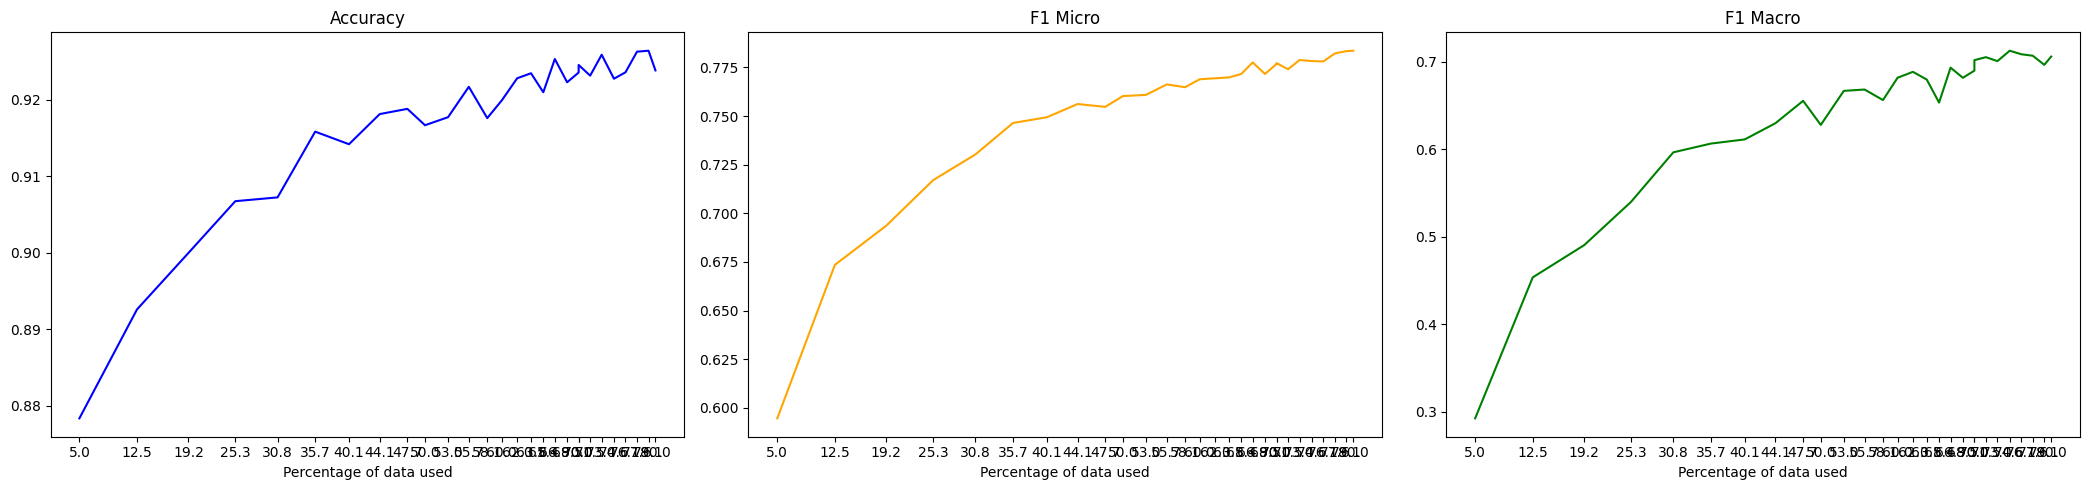

In [ ]:
active_learning(seeds[3], 3)

## RUN 5

TRIAL 5
Random seed: 94
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6165, Accuracy: 0.8139, F1 Micro: 0.2102, F1 Macro: 0.0951
Epoch 2/10, Train Loss: 0.468, Accuracy: 0.8347, F1 Micro: 0.1344, F1 Macro: 0.045
Epoch 3/10, Train Loss: 0.4255, Accuracy: 0.8353, F1 Micro: 0.1217, F1 Macro: 0.0464
Epoch 4/10, Train Loss: 0.3983, Accuracy: 0.8415, F1 Micro: 0.2027, F1 Macro: 0.0719
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3777, Accuracy: 0.8462, F1 Micro: 0.2592, F1 Macro: 0.0889
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3832, Accuracy: 0.8553, F1 Micro: 0.3911, F1 Macro: 0.1316
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3463, Accuracy: 0.8657, F1 Micro: 0.4614, F1 Macro: 0.1993
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3236, Accuracy: 0.8764, F1 Micro: 0.5703, F1 Macro: 0.263
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2907, Accuracy: 0.8803, F1 Micro: 0.6029, F1 Macro: 0.2845
Higher F1 achieved, saving model
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5356, Accuracy: 0.8295, F1 Micro: 0.0481, F1 Macro: 0.0194
Epoch 2/10, Train Loss: 0.402, Accuracy: 0.8273, F1 Micro: 0.0061, F1 Macro: 0.0028
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3777, Accuracy: 0.8545, F1 Micro: 0.3718, F1 Macro: 0.1151
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3416, Accuracy: 0.8764, F1 Micro: 0.5903, F1 Macro: 0.2691
Epoch 5/10, Train Loss: 0.3241, Accuracy: 0.8841, F1 Micro: 0.5779, F1 Macro: 0.2713
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2787, Accuracy: 0.8916, F1 Micro: 0.6349, F1 Macro: 0.3325
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2459, Accuracy: 0.8937, F1 Micro: 0.6542, F1 Macro: 0.3574
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2205, Accuracy: 0.8948, F1 Micro: 0.702, F1 Macro: 0.4514
Epoch 9/10, Train Loss: 0.2026, Accuracy: 0.9001, F1 Micro: 0.6967, F1 Macro: 0.4855
Epoch 10/10, Train Loss: 0.1866, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.487, Accuracy: 0.8273, F1 Micro: 0.0071, F1 Macro: 0.0032
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3768, Accuracy: 0.8471, F1 Micro: 0.2584, F1 Macro: 0.0894
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3389, Accuracy: 0.8723, F1 Micro: 0.475, F1 Macro: 0.2152
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2984, Accuracy: 0.8894, F1 Micro: 0.637, F1 Macro: 0.32
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2603, Accuracy: 0.8961, F1 Micro: 0.6789, F1 Macro: 0.3928
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2275, Accuracy: 0.9015, F1 Micro: 0.6958, F1 Macro: 0.4208
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1959, Accuracy: 0.9043, F1 Micro: 0.7042, F1 Macro: 0.4758
Epoch 8/10, Train Loss: 0.1712, Accuracy: 0.906, F1 Micro: 0.7033, F1 Macro: 0.4914
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1503, Accuracy: 0.9056, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.457, Accuracy: 0.8268, F1 Micro: 0.0007, F1 Macro: 0.0003
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3654, Accuracy: 0.8666, F1 Micro: 0.4443, F1 Macro: 0.1692
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3069, Accuracy: 0.8892, F1 Micro: 0.6331, F1 Macro: 0.3328
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2619, Accuracy: 0.8985, F1 Micro: 0.6967, F1 Macro: 0.4421
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2225, Accuracy: 0.9064, F1 Micro: 0.6979, F1 Macro: 0.4686
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1985, Accuracy: 0.906, F1 Micro: 0.7224, F1 Macro: 0.5096
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1734, Accuracy: 0.9076, F1 Micro: 0.7369, F1 Macro: 0.539
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.146, Accuracy: 0.912, F1 Micro: 0.7383, F1 Macro: 0.5479
Epoch 9/10, Train Loss: 0.1284, Accuracy: 0.913, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4527, Accuracy: 0.844, F1 Micro: 0.2227, F1 Macro: 0.0776
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3528, Accuracy: 0.8801, F1 Micro: 0.5742, F1 Macro: 0.2632
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.296, Accuracy: 0.8964, F1 Micro: 0.6669, F1 Macro: 0.3427
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2519, Accuracy: 0.8997, F1 Micro: 0.7114, F1 Macro: 0.4663
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2219, Accuracy: 0.9046, F1 Micro: 0.7315, F1 Macro: 0.5287
Epoch 6/10, Train Loss: 0.1891, Accuracy: 0.9112, F1 Micro: 0.7274, F1 Macro: 0.5185
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1624, Accuracy: 0.9122, F1 Micro: 0.7416, F1 Macro: 0.5636
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1429, Accuracy: 0.9119, F1 Micro: 0.7484, F1 Macro: 0.5648
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1176, Accuracy: 0.9119, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4411, Accuracy: 0.8472, F1 Micro: 0.2556, F1 Macro: 0.0888
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3388, Accuracy: 0.8874, F1 Micro: 0.6112, F1 Macro: 0.2979
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2779, Accuracy: 0.9003, F1 Micro: 0.6636, F1 Macro: 0.4191
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.244, Accuracy: 0.9073, F1 Micro: 0.7024, F1 Macro: 0.4741
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2084, Accuracy: 0.9123, F1 Micro: 0.7429, F1 Macro: 0.5561
Epoch 6/10, Train Loss: 0.1759, Accuracy: 0.9134, F1 Micro: 0.7416, F1 Macro: 0.5521
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1483, Accuracy: 0.9141, F1 Micro: 0.7498, F1 Macro: 0.5589
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1308, Accuracy: 0.9121, F1 Micro: 0.7547, F1 Macro: 0.5968
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1133, Accuracy: 0.9183, F1 Micr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4349, Accuracy: 0.851, F1 Micro: 0.2947, F1 Macro: 0.0987
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.326, Accuracy: 0.8918, F1 Micro: 0.6316, F1 Macro: 0.3258
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2674, Accuracy: 0.9057, F1 Micro: 0.7043, F1 Macro: 0.5016
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2285, Accuracy: 0.9119, F1 Micro: 0.7281, F1 Macro: 0.5242
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1942, Accuracy: 0.9148, F1 Micro: 0.748, F1 Macro: 0.5752
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1687, Accuracy: 0.9174, F1 Micro: 0.7519, F1 Macro: 0.585
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1413, Accuracy: 0.9199, F1 Micro: 0.7646, F1 Macro: 0.5866
Epoch 8/10, Train Loss: 0.116, Accuracy: 0.9124, F1 Micro: 0.7569, F1 Macro: 0.5994
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1044, Accuracy: 0.919, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4299, Accuracy: 0.8583, F1 Micro: 0.4117, F1 Macro: 0.1233
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3191, Accuracy: 0.8953, F1 Micro: 0.6728, F1 Macro: 0.3735
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2587, Accuracy: 0.9086, F1 Micro: 0.7223, F1 Macro: 0.5174
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2208, Accuracy: 0.914, F1 Micro: 0.7334, F1 Macro: 0.552
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1889, Accuracy: 0.9133, F1 Micro: 0.7527, F1 Macro: 0.5686
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1562, Accuracy: 0.9179, F1 Micro: 0.7636, F1 Macro: 0.5905
Epoch 7/10, Train Loss: 0.1359, Accuracy: 0.9164, F1 Micro: 0.7626, F1 Macro: 0.6115
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1171, Accuracy: 0.9213, F1 Micro: 0.7646, F1 Macro: 0.6086
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0982, Accuracy: 0.9213, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4242, Accuracy: 0.8623, F1 Micro: 0.4112, F1 Macro: 0.1386
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3106, Accuracy: 0.8956, F1 Micro: 0.6435, F1 Macro: 0.3416
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2554, Accuracy: 0.9107, F1 Micro: 0.7182, F1 Macro: 0.5091
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.216, Accuracy: 0.9143, F1 Micro: 0.7431, F1 Macro: 0.563
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1854, Accuracy: 0.9176, F1 Micro: 0.7462, F1 Macro: 0.5629
Epoch 6/10, Train Loss: 0.1523, Accuracy: 0.9174, F1 Micro: 0.7445, F1 Macro: 0.5773
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1282, Accuracy: 0.919, F1 Micro: 0.7665, F1 Macro: 0.6115
Epoch 8/10, Train Loss: 0.1095, Accuracy: 0.9183, F1 Micro: 0.7664, F1 Macro: 0.6086
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0947, Accuracy: 0.9186, F1 Micro: 0.7694, F1 Macro: 0.6203
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4157, Accuracy: 0.8735, F1 Micro: 0.519, F1 Macro: 0.2179
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3005, Accuracy: 0.8979, F1 Micro: 0.6601, F1 Macro: 0.398
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2484, Accuracy: 0.911, F1 Micro: 0.7189, F1 Macro: 0.5094
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.212, Accuracy: 0.9156, F1 Micro: 0.7451, F1 Macro: 0.5606
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1832, Accuracy: 0.9194, F1 Micro: 0.7506, F1 Macro: 0.5857
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1498, Accuracy: 0.9207, F1 Micro: 0.7602, F1 Macro: 0.588
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.127, Accuracy: 0.9215, F1 Micro: 0.7694, F1 Macro: 0.6216
Epoch 8/10, Train Loss: 0.1073, Accuracy: 0.9203, F1 Micro: 0.7693, F1 Macro: 0.6243
Epoch 9/10, Train Loss: 0.0932, Accuracy: 0.9175, F1 Micro: 0.7569, F1 Macro: 0.6145
Higher F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4136, Accuracy: 0.8721, F1 Micro: 0.4877, F1 Macro: 0.2067
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2968, Accuracy: 0.9011, F1 Micro: 0.6793, F1 Macro: 0.3846
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2439, Accuracy: 0.9065, F1 Micro: 0.7319, F1 Macro: 0.5593
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2141, Accuracy: 0.9171, F1 Micro: 0.747, F1 Macro: 0.5744
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1759, Accuracy: 0.9211, F1 Micro: 0.7598, F1 Macro: 0.587
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1504, Accuracy: 0.9227, F1 Micro: 0.7727, F1 Macro: 0.6131
Epoch 7/10, Train Loss: 0.1288, Accuracy: 0.922, F1 Micro: 0.7723, F1 Macro: 0.6192
Epoch 8/10, Train Loss: 0.1134, Accuracy: 0.9234, F1 Micro: 0.7657, F1 Macro: 0.6223
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0906, Accuracy: 0.9201, F1 Micro: 0.773, F1 Macro: 0.6296
Higher F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4153, Accuracy: 0.8788, F1 Micro: 0.5857, F1 Macro: 0.2661
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2933, Accuracy: 0.9041, F1 Micro: 0.7156, F1 Macro: 0.5057
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2384, Accuracy: 0.914, F1 Micro: 0.7412, F1 Macro: 0.5387
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2025, Accuracy: 0.9151, F1 Micro: 0.7503, F1 Macro: 0.5456
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1773, Accuracy: 0.9214, F1 Micro: 0.7558, F1 Macro: 0.5786
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1484, Accuracy: 0.9215, F1 Micro: 0.7581, F1 Macro: 0.5949
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1239, Accuracy: 0.9244, F1 Micro: 0.7716, F1 Macro: 0.6249
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1011, Accuracy: 0.924, F1 Micro: 0.7755, F1 Macro: 0.6297
Epoch 9/10, Train Loss: 0.0853, Accuracy: 0.9233, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4107, Accuracy: 0.8801, F1 Micro: 0.5891, F1 Macro: 0.2749
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2904, Accuracy: 0.9044, F1 Micro: 0.6985, F1 Macro: 0.4427
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2379, Accuracy: 0.9138, F1 Micro: 0.7368, F1 Macro: 0.5185
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2015, Accuracy: 0.9184, F1 Micro: 0.7511, F1 Macro: 0.5633
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1733, Accuracy: 0.9222, F1 Micro: 0.7644, F1 Macro: 0.6008
Epoch 6/10, Train Loss: 0.1436, Accuracy: 0.9212, F1 Micro: 0.7641, F1 Macro: 0.6143
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.124, Accuracy: 0.9235, F1 Micro: 0.7731, F1 Macro: 0.6361
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.104, Accuracy: 0.925, F1 Micro: 0.7744, F1 Macro: 0.6443
Epoch 9/10, Train Loss: 0.0864, Accuracy: 0.9204, F1 Micro: 0.7705, F1 Macro: 0.6488
Higher 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4086, Accuracy: 0.8793, F1 Micro: 0.5566, F1 Macro: 0.2558
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2847, Accuracy: 0.9068, F1 Micro: 0.7143, F1 Macro: 0.5027
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2336, Accuracy: 0.9115, F1 Micro: 0.73, F1 Macro: 0.5306
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1979, Accuracy: 0.9207, F1 Micro: 0.7628, F1 Macro: 0.5986
Epoch 5/10, Train Loss: 0.1687, Accuracy: 0.9216, F1 Micro: 0.7597, F1 Macro: 0.6107
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1445, Accuracy: 0.9239, F1 Micro: 0.7702, F1 Macro: 0.6179
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1189, Accuracy: 0.9191, F1 Micro: 0.7711, F1 Macro: 0.6262
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1, Accuracy: 0.9264, F1 Micro: 0.7769, F1 Macro: 0.6509
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0834, Accuracy: 0.926, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4069, Accuracy: 0.8805, F1 Micro: 0.6074, F1 Macro: 0.2867
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2891, Accuracy: 0.9056, F1 Micro: 0.7164, F1 Macro: 0.4794
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2351, Accuracy: 0.9128, F1 Micro: 0.7445, F1 Macro: 0.5525
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1994, Accuracy: 0.9202, F1 Micro: 0.7693, F1 Macro: 0.5979
Epoch 5/10, Train Loss: 0.1726, Accuracy: 0.9226, F1 Micro: 0.7574, F1 Macro: 0.5912
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1431, Accuracy: 0.9257, F1 Micro: 0.7705, F1 Macro: 0.6182
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1195, Accuracy: 0.9206, F1 Micro: 0.7761, F1 Macro: 0.642
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1018, Accuracy: 0.922, F1 Micro: 0.778, F1 Macro: 0.6459
Epoch 9/10, Train Loss: 0.0862, Accuracy: 0.9243, F1 Micro: 0.7761, F1 Macro: 0.6675
Higher 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4001, Accuracy: 0.8813, F1 Micro: 0.6348, F1 Macro: 0.3084
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2798, Accuracy: 0.9075, F1 Micro: 0.717, F1 Macro: 0.4901
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2291, Accuracy: 0.9176, F1 Micro: 0.7409, F1 Macro: 0.5606
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1969, Accuracy: 0.9211, F1 Micro: 0.7619, F1 Macro: 0.5964
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1618, Accuracy: 0.9237, F1 Micro: 0.7759, F1 Macro: 0.6209
Epoch 6/10, Train Loss: 0.1373, Accuracy: 0.9258, F1 Micro: 0.7742, F1 Macro: 0.6392
Epoch 7/10, Train Loss: 0.1174, Accuracy: 0.9248, F1 Micro: 0.7686, F1 Macro: 0.6386
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0997, Accuracy: 0.9277, F1 Micro: 0.7847, F1 Macro: 0.6635
Epoch 9/10, Train Loss: 0.0866, Accuracy: 0.9272, F1 Micro: 0.7806, F1 Macro: 0.666
Epoch 10/10, Train Loss: 0.074, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3984, Accuracy: 0.8839, F1 Micro: 0.6073, F1 Macro: 0.3003
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2793, Accuracy: 0.9086, F1 Micro: 0.7165, F1 Macro: 0.4941
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2321, Accuracy: 0.9162, F1 Micro: 0.7353, F1 Macro: 0.5589
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1934, Accuracy: 0.9192, F1 Micro: 0.7661, F1 Macro: 0.6096
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1618, Accuracy: 0.9187, F1 Micro: 0.7718, F1 Macro: 0.6198
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1384, Accuracy: 0.9251, F1 Micro: 0.777, F1 Macro: 0.6259
Epoch 7/10, Train Loss: 0.1203, Accuracy: 0.9197, F1 Micro: 0.7744, F1 Macro: 0.6429
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0995, Accuracy: 0.9245, F1 Micro: 0.7825, F1 Macro: 0.6617
Epoch 9/10, Train Loss: 0.082, Accuracy: 0.9232, F1 Micro: 0.7738, F1 Macro: 0.64
Higher F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.391, Accuracy: 0.8848, F1 Micro: 0.6059, F1 Macro: 0.2937
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2723, Accuracy: 0.9061, F1 Micro: 0.7199, F1 Macro: 0.4977
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2241, Accuracy: 0.9162, F1 Micro: 0.7468, F1 Macro: 0.5725
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1921, Accuracy: 0.9173, F1 Micro: 0.7628, F1 Macro: 0.5878
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1606, Accuracy: 0.9204, F1 Micro: 0.7713, F1 Macro: 0.6107
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1333, Accuracy: 0.9249, F1 Micro: 0.7834, F1 Macro: 0.6476
Epoch 7/10, Train Loss: 0.1122, Accuracy: 0.9248, F1 Micro: 0.7815, F1 Macro: 0.6653
Epoch 8/10, Train Loss: 0.0979, Accuracy: 0.9252, F1 Micro: 0.7722, F1 Macro: 0.6514
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0844, Accuracy: 0.9266, F1 Micro: 0.7841, F1 Macro: 0.6758
Highe

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3955, Accuracy: 0.8869, F1 Micro: 0.624, F1 Macro: 0.3074
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2734, Accuracy: 0.9053, F1 Micro: 0.7284, F1 Macro: 0.5049
Epoch 3/10, Train Loss: 0.224, Accuracy: 0.916, F1 Micro: 0.7274, F1 Macro: 0.5592
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1883, Accuracy: 0.9201, F1 Micro: 0.7676, F1 Macro: 0.6071
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1569, Accuracy: 0.9248, F1 Micro: 0.7732, F1 Macro: 0.6225
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1347, Accuracy: 0.923, F1 Micro: 0.7763, F1 Macro: 0.6502
Epoch 7/10, Train Loss: 0.1121, Accuracy: 0.9258, F1 Micro: 0.7732, F1 Macro: 0.6474
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0932, Accuracy: 0.9274, F1 Micro: 0.7784, F1 Macro: 0.6688
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.081, Accuracy: 0.9282, F1 Micro: 0.7806, F1 Macro: 0.6811
Higher F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3954, Accuracy: 0.8873, F1 Micro: 0.6277, F1 Macro: 0.3185
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2716, Accuracy: 0.9088, F1 Micro: 0.7046, F1 Macro: 0.4967
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2223, Accuracy: 0.9182, F1 Micro: 0.7398, F1 Macro: 0.5535
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1939, Accuracy: 0.9226, F1 Micro: 0.7711, F1 Macro: 0.6193
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1576, Accuracy: 0.9258, F1 Micro: 0.7784, F1 Macro: 0.6196
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.134, Accuracy: 0.926, F1 Micro: 0.7808, F1 Macro: 0.6352
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1113, Accuracy: 0.9277, F1 Micro: 0.7859, F1 Macro: 0.6687
Epoch 8/10, Train Loss: 0.0999, Accuracy: 0.9276, F1 Micro: 0.7838, F1 Macro: 0.6721
Epoch 9/10, Train Loss: 0.0842, Accuracy: 0.9235, F1 Micro: 0.7811, F1 Macro: 0.6901
Higher

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.39, Accuracy: 0.8882, F1 Micro: 0.6216, F1 Macro: 0.3165
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2715, Accuracy: 0.9082, F1 Micro: 0.7214, F1 Macro: 0.5017
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2255, Accuracy: 0.9167, F1 Micro: 0.7563, F1 Macro: 0.574
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1892, Accuracy: 0.9248, F1 Micro: 0.7726, F1 Macro: 0.62
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1543, Accuracy: 0.9236, F1 Micro: 0.7729, F1 Macro: 0.6328
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.133, Accuracy: 0.9232, F1 Micro: 0.7798, F1 Macro: 0.6426
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1147, Accuracy: 0.9266, F1 Micro: 0.7851, F1 Macro: 0.6665
Epoch 8/10, Train Loss: 0.091, Accuracy: 0.9273, F1 Micro: 0.7851, F1 Macro: 0.6761
Epoch 9/10, Train Loss: 0.0782, Accuracy: 0.9259, F1 Micro: 0.7824, F1 Macro: 0.6792
Higher F1 a

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3913, Accuracy: 0.8885, F1 Micro: 0.6243, F1 Macro: 0.3152
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2713, Accuracy: 0.9095, F1 Micro: 0.7274, F1 Macro: 0.5355
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2248, Accuracy: 0.9186, F1 Micro: 0.7458, F1 Macro: 0.5537
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1868, Accuracy: 0.9188, F1 Micro: 0.7692, F1 Macro: 0.611
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1531, Accuracy: 0.9251, F1 Micro: 0.781, F1 Macro: 0.6395
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1327, Accuracy: 0.9267, F1 Micro: 0.7842, F1 Macro: 0.6592
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1129, Accuracy: 0.9266, F1 Micro: 0.7848, F1 Macro: 0.6664
Epoch 8/10, Train Loss: 0.0928, Accuracy: 0.928, F1 Micro: 0.7788, F1 Macro: 0.682
Epoch 9/10, Train Loss: 0.0786, Accuracy: 0.925, F1 Micro: 0.7838, F1 Macro: 0.6844
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3878, Accuracy: 0.8893, F1 Micro: 0.6347, F1 Macro: 0.3187
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2669, Accuracy: 0.9089, F1 Micro: 0.7088, F1 Macro: 0.5017
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2208, Accuracy: 0.9194, F1 Micro: 0.75, F1 Macro: 0.5691
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1863, Accuracy: 0.9244, F1 Micro: 0.7704, F1 Macro: 0.6175
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.153, Accuracy: 0.9273, F1 Micro: 0.7761, F1 Macro: 0.6476
Epoch 6/10, Train Loss: 0.1305, Accuracy: 0.9252, F1 Micro: 0.7606, F1 Macro: 0.6128
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.11, Accuracy: 0.9243, F1 Micro: 0.7827, F1 Macro: 0.6913
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0927, Accuracy: 0.9274, F1 Micro: 0.7841, F1 Macro: 0.68
Epoch 9/10, Train Loss: 0.0786, Accuracy: 0.9212, F1 Micro: 0.7742, F1 Macro: 0.6922
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3886, Accuracy: 0.8896, F1 Micro: 0.6447, F1 Macro: 0.3247
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2626, Accuracy: 0.9114, F1 Micro: 0.7173, F1 Macro: 0.5197
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2169, Accuracy: 0.9201, F1 Micro: 0.7613, F1 Macro: 0.5932
Epoch 4/10, Train Loss: 0.1817, Accuracy: 0.9236, F1 Micro: 0.7611, F1 Macro: 0.5944
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.152, Accuracy: 0.9244, F1 Micro: 0.78, F1 Macro: 0.6218
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1284, Accuracy: 0.9266, F1 Micro: 0.7816, F1 Macro: 0.645
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1135, Accuracy: 0.9259, F1 Micro: 0.7838, F1 Macro: 0.6634
Epoch 8/10, Train Loss: 0.0937, Accuracy: 0.926, F1 Micro: 0.783, F1 Macro: 0.6934
Epoch 9/10, Train Loss: 0.0768, Accuracy: 0.9263, F1 Micro: 0.7831, F1 Macro: 0.7028
Epoch 10/10, Train Loss: 0.0682, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.382, Accuracy: 0.8884, F1 Micro: 0.5968, F1 Macro: 0.3057
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2583, Accuracy: 0.9117, F1 Micro: 0.7224, F1 Macro: 0.5329
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2164, Accuracy: 0.9198, F1 Micro: 0.7545, F1 Macro: 0.5655
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1767, Accuracy: 0.9219, F1 Micro: 0.7797, F1 Macro: 0.6298
Epoch 5/10, Train Loss: 0.1511, Accuracy: 0.9269, F1 Micro: 0.7754, F1 Macro: 0.6325
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1286, Accuracy: 0.9289, F1 Micro: 0.7885, F1 Macro: 0.6595
Epoch 7/10, Train Loss: 0.1097, Accuracy: 0.9288, F1 Micro: 0.7833, F1 Macro: 0.6807
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0864, Accuracy: 0.9297, F1 Micro: 0.7894, F1 Macro: 0.6919
Epoch 9/10, Train Loss: 0.0737, Accuracy: 0.9244, F1 Micro: 0.7798, F1 Macro: 0.6974
Higher F1 achieved, saving model
Epoch

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3841, Accuracy: 0.8915, F1 Micro: 0.6662, F1 Macro: 0.3786
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2569, Accuracy: 0.9099, F1 Micro: 0.7276, F1 Macro: 0.4993
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2109, Accuracy: 0.9158, F1 Micro: 0.7532, F1 Macro: 0.6057
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1753, Accuracy: 0.9251, F1 Micro: 0.7639, F1 Macro: 0.6151
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1509, Accuracy: 0.9255, F1 Micro: 0.7734, F1 Macro: 0.6261
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1287, Accuracy: 0.9265, F1 Micro: 0.7828, F1 Macro: 0.6442
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1081, Accuracy: 0.9255, F1 Micro: 0.7844, F1 Macro: 0.6742
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0904, Accuracy: 0.9302, F1 Micro: 0.7904, F1 Macro: 0.6826
Epoch 9/10, Train Loss: 0.0776, Accuracy: 0.924, F1 Micr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3753, Accuracy: 0.89, F1 Micro: 0.6151, F1 Macro: 0.3043
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2569, Accuracy: 0.9102, F1 Micro: 0.73, F1 Macro: 0.5358
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2093, Accuracy: 0.918, F1 Micro: 0.7532, F1 Macro: 0.5579
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1764, Accuracy: 0.9226, F1 Micro: 0.7762, F1 Macro: 0.6294
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1454, Accuracy: 0.9267, F1 Micro: 0.7804, F1 Macro: 0.6438
Epoch 6/10, Train Loss: 0.1226, Accuracy: 0.9193, F1 Micro: 0.778, F1 Macro: 0.6673
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1045, Accuracy: 0.9254, F1 Micro: 0.7829, F1 Macro: 0.6929
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0891, Accuracy: 0.9264, F1 Micro: 0.7877, F1 Macro: 0.7075
Epoch 9/10, Train Loss: 0.0732, Accuracy: 0.9249, F1 Micro: 0.7873, F1 Macro: 0.7163
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3749, Accuracy: 0.894, F1 Micro: 0.6444, F1 Macro: 0.342
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2512, Accuracy: 0.9049, F1 Micro: 0.6656, F1 Macro: 0.4383
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2069, Accuracy: 0.9211, F1 Micro: 0.7617, F1 Macro: 0.5896
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1687, Accuracy: 0.9248, F1 Micro: 0.7682, F1 Macro: 0.6109
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1451, Accuracy: 0.9233, F1 Micro: 0.7815, F1 Macro: 0.6552
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1199, Accuracy: 0.9292, F1 Micro: 0.7867, F1 Macro: 0.6587
Epoch 7/10, Train Loss: 0.0988, Accuracy: 0.9258, F1 Micro: 0.7807, F1 Macro: 0.6462
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0846, Accuracy: 0.931, F1 Micro: 0.7927, F1 Macro: 0.7012
Epoch 9/10, Train Loss: 0.0691, Accuracy: 0.9275, F1 Micro: 0.7868, F1 Macro: 0.6952
Epoch 1

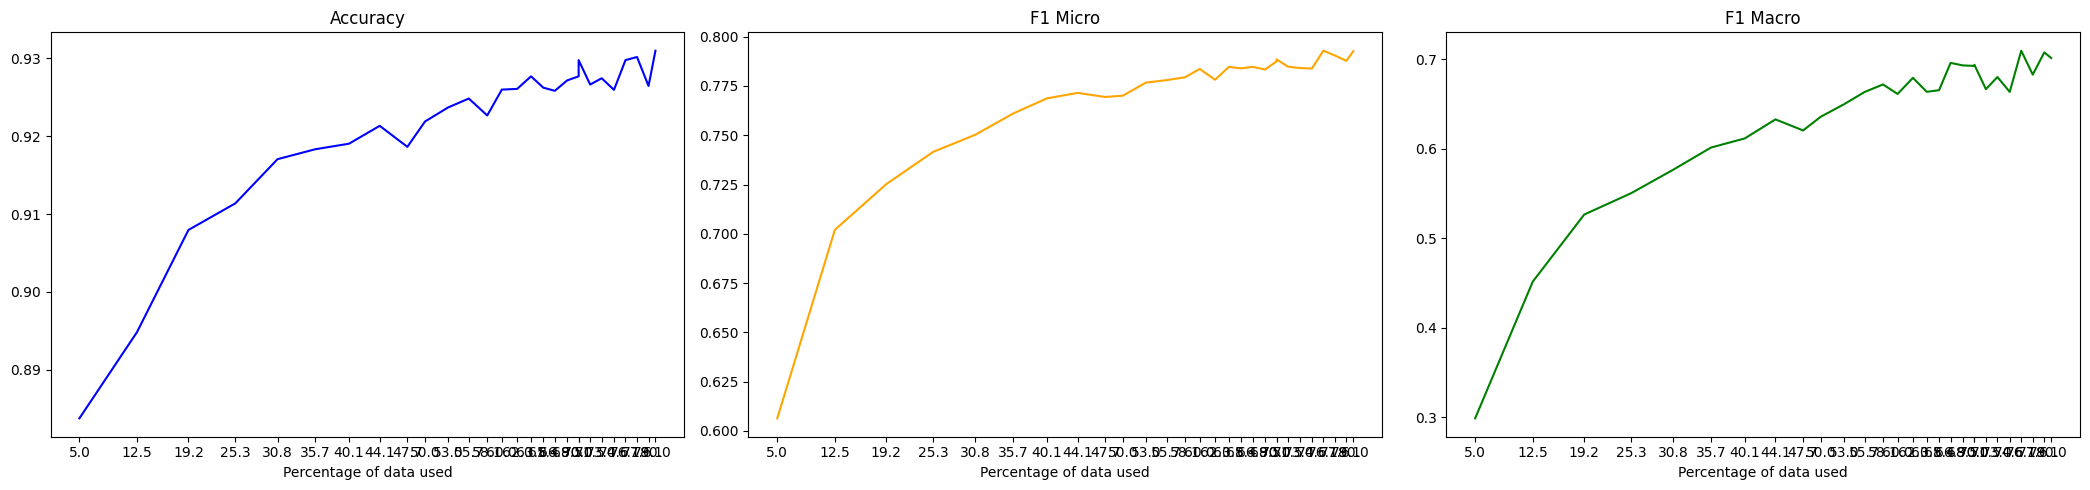

In [ ]:
active_learning(seeds[4], 4)